In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D

import xspec as x
#import os

#%matplotlib notebook

#import sys
#sys.stdout = open('/dev/stdout', 'w')
#sys.stderr = open('/dev/stderr', 'w')

#%load_ext autoreload
#%autoreload 1

In [2]:
x.Xset.chatter = 0
#x.Xset.logChatter = 25
logFile = x.Xset.openLog("newLogFile.txt")

# 1. LINES ONLY

В этом блоке представлен алгоритм для вычисления $T_{spec}$ по спектрам (с преобладанием линий) двухкомпонентной плазмы разными способами и отображения его как на Рис.3 из публикации Вихлинина.

## 1.1 $T_{spec}$ from E(T)

In [3]:
%run -i 'utils/ave_lines.py'

## 1.2 $T_{spec}$ for lines from direct fit

Drawing routine. Also performs `fakeit` and `steppar`.

In [4]:
%run -i 'utils/fit_main.py'

## PyXspec

Defining a function that calculates single-temperature fit for two-component plasma (with line-dominated spectra) of temperatures $T_{min}$ and $T_{max}$ and relative contributions $f_{min}$ and $f_{max}$ respectively.

Note: to get rid of trace elements for pure bremsstrahlung use `xset APEC_TRACE_ABUND 0`.

<Figure size 640x480 with 0 Axes>

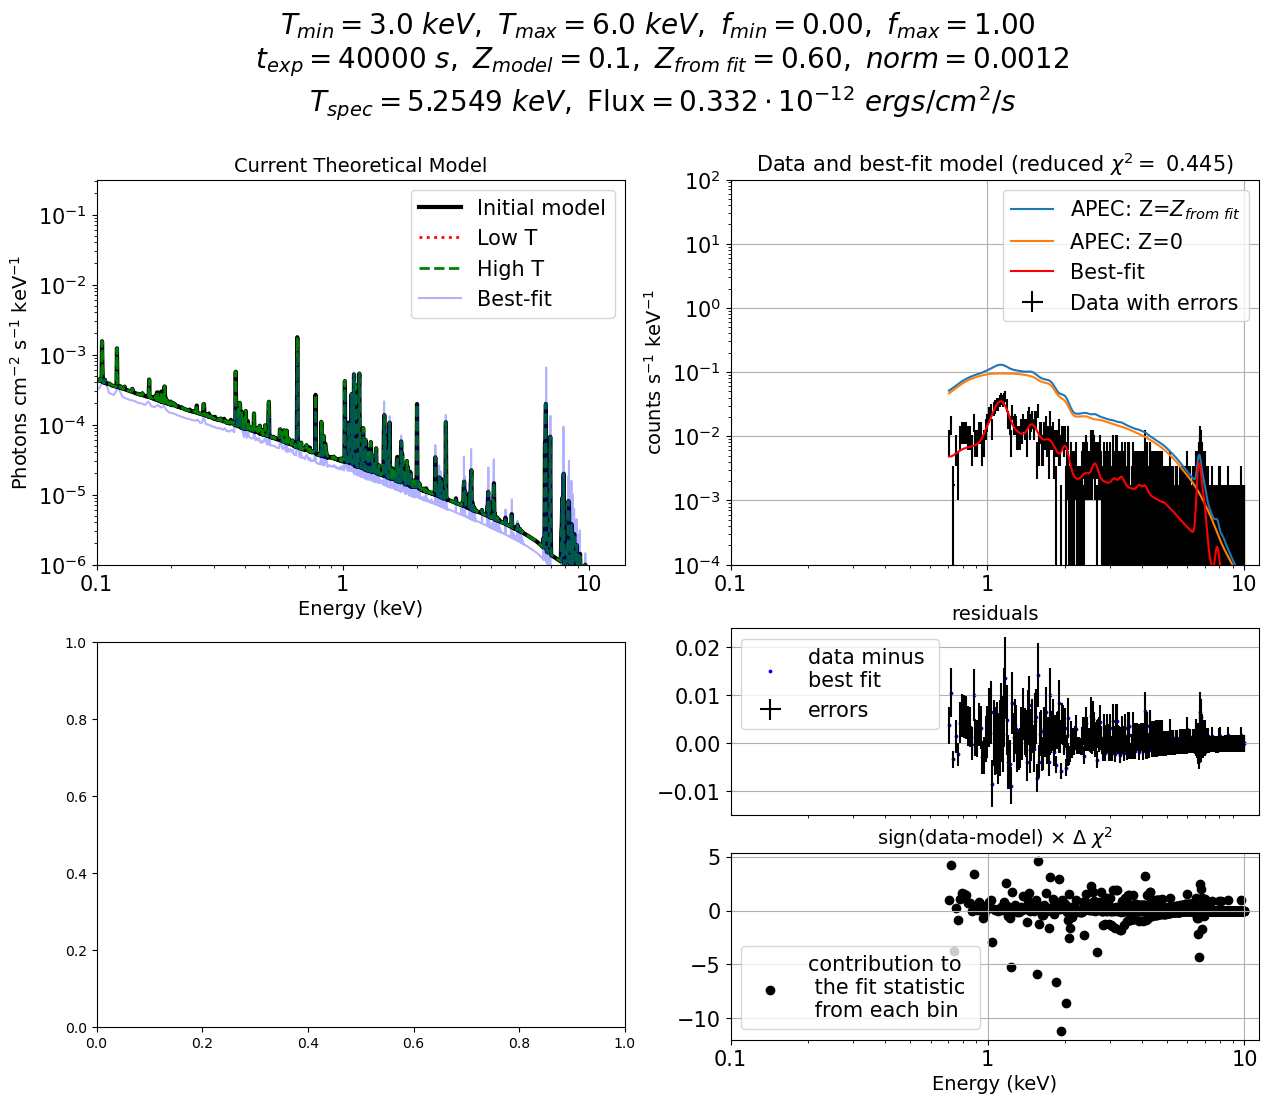

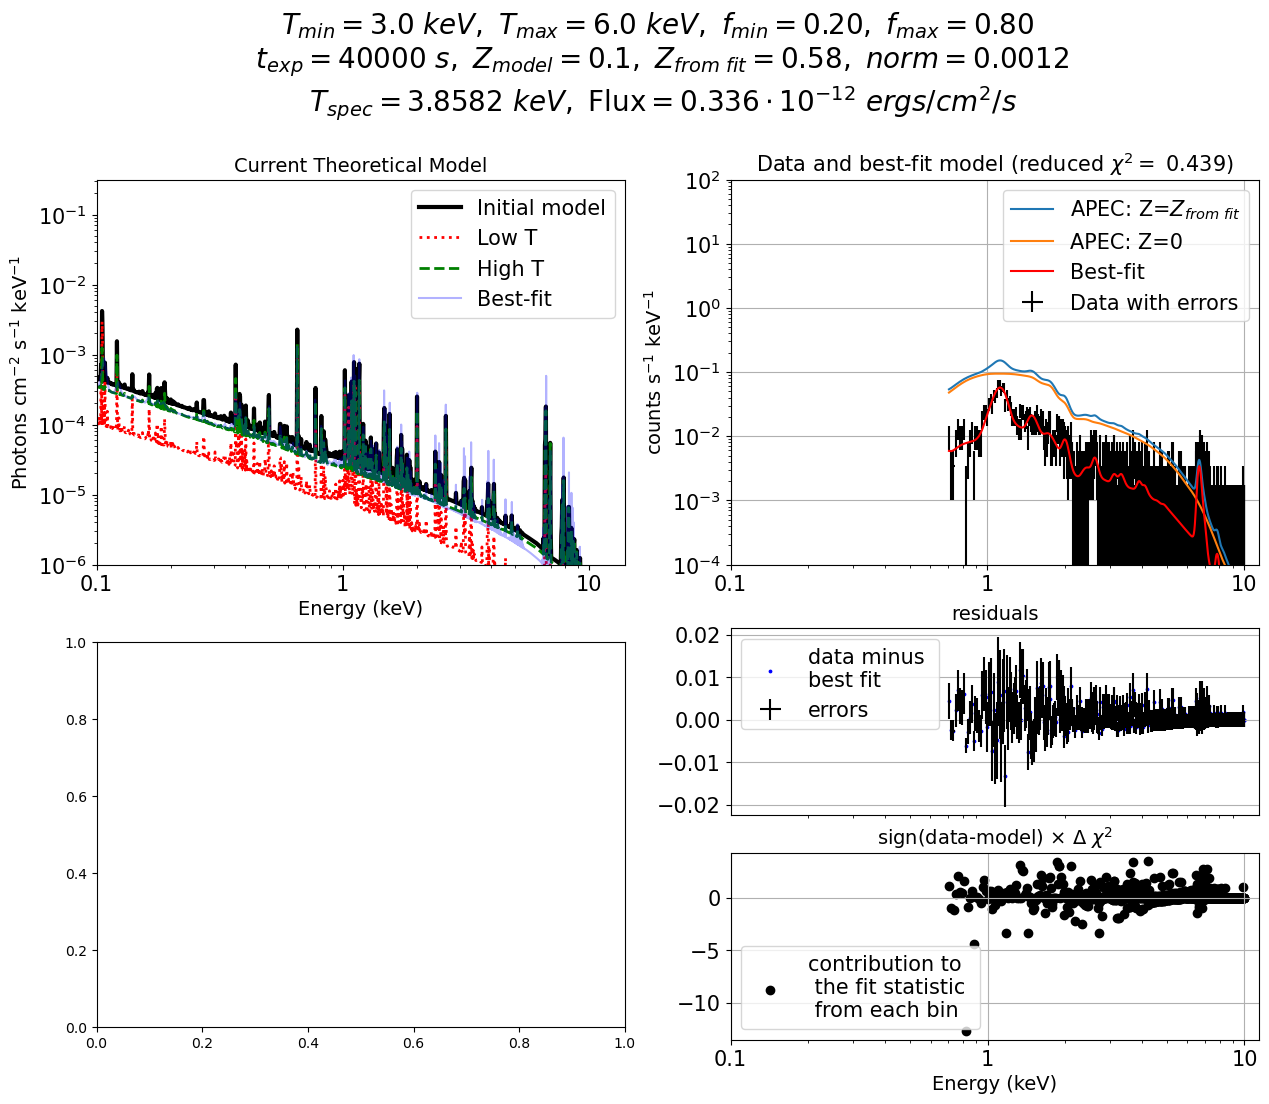

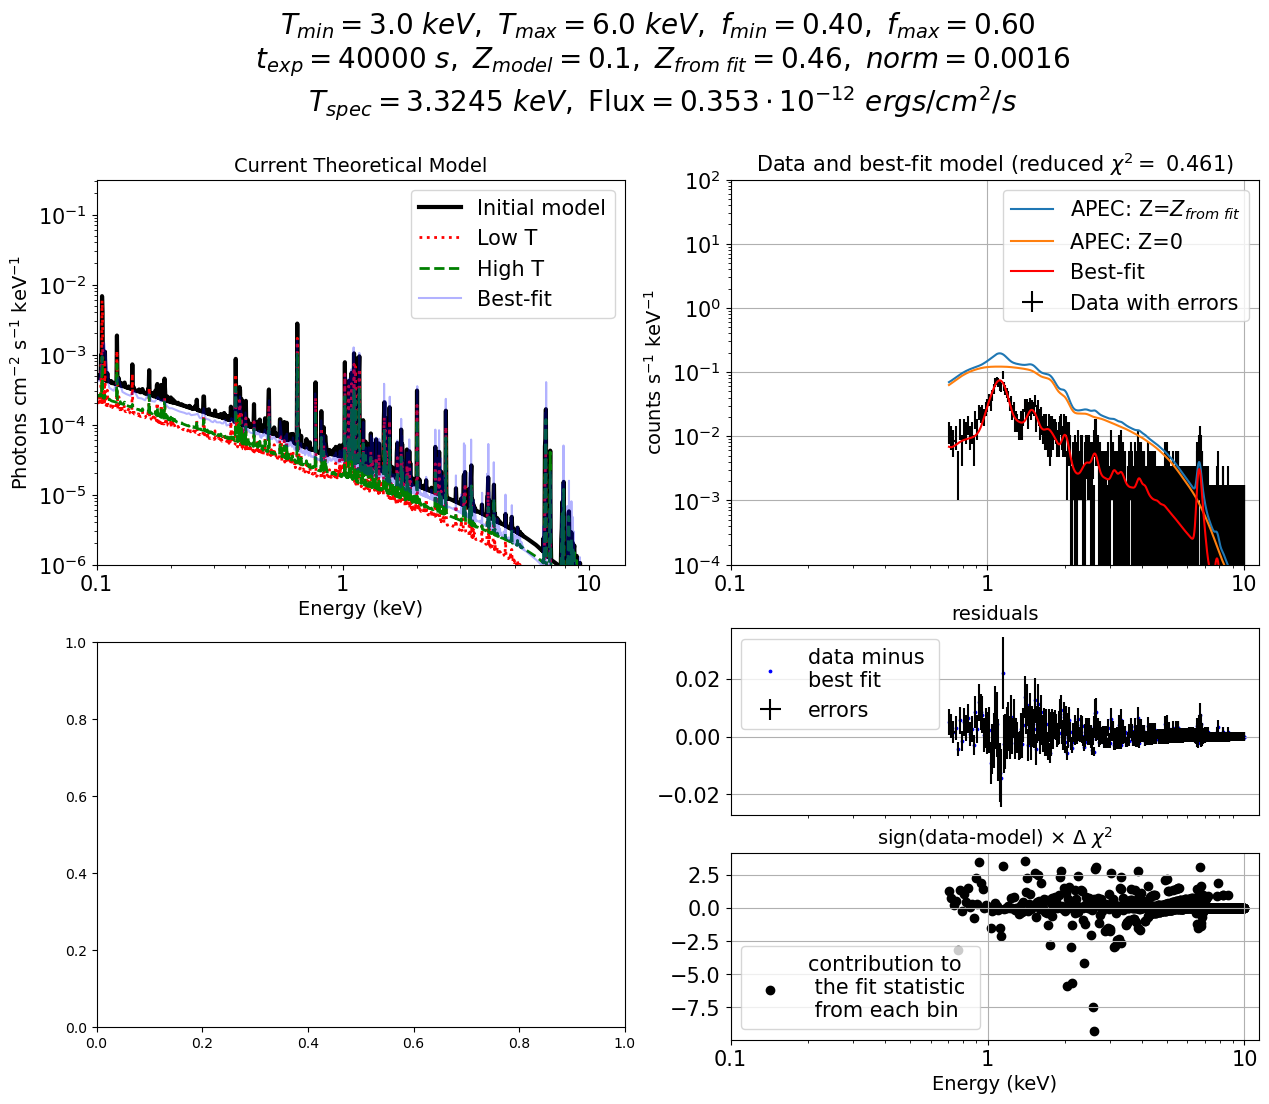

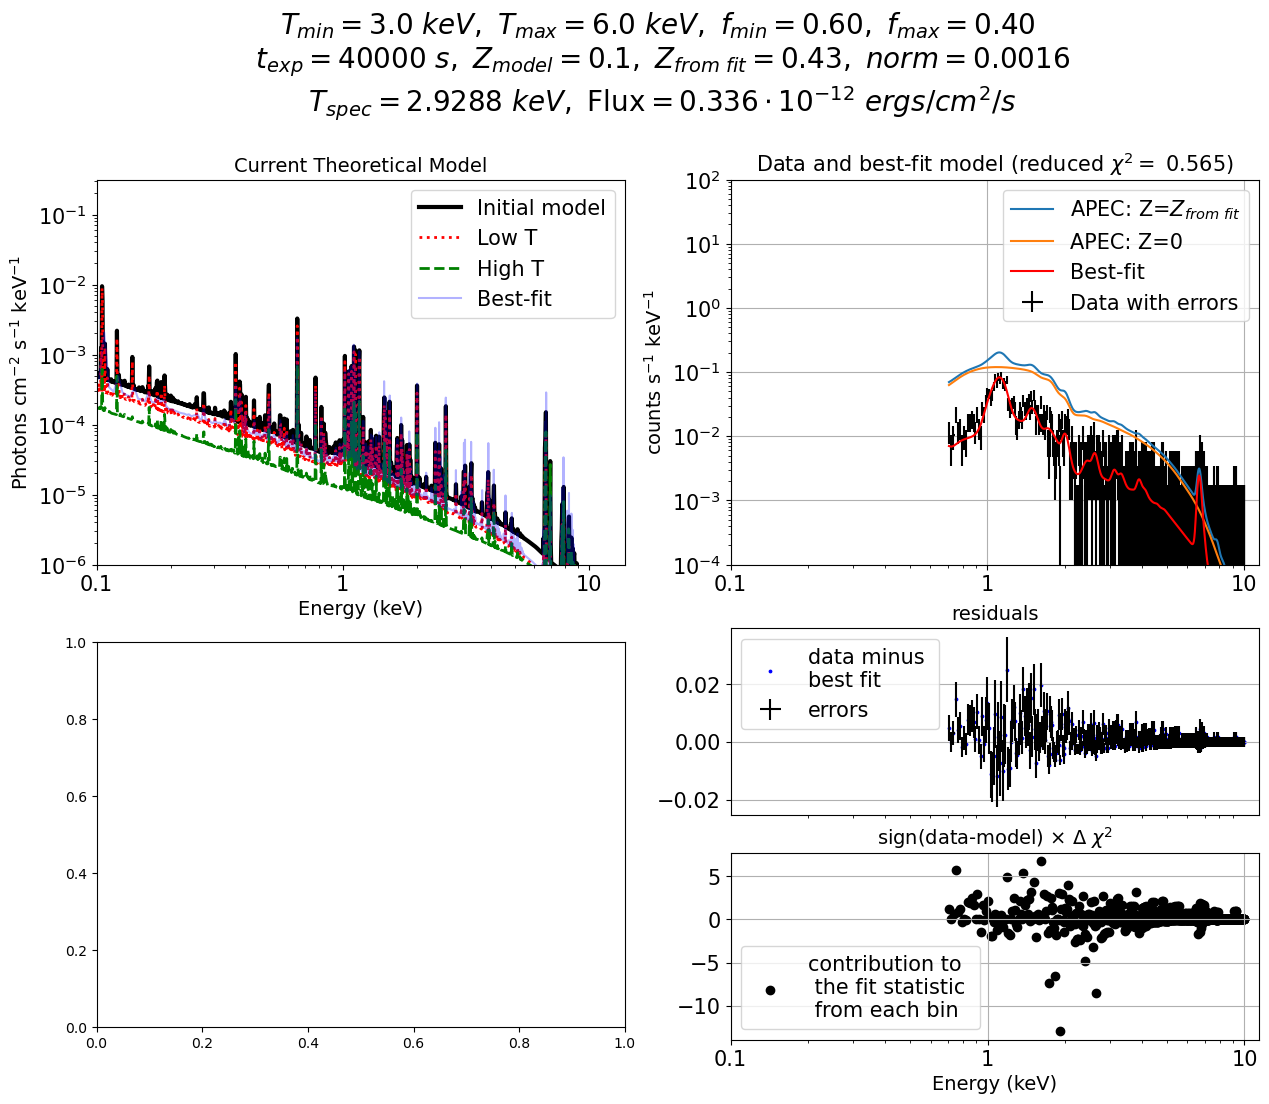

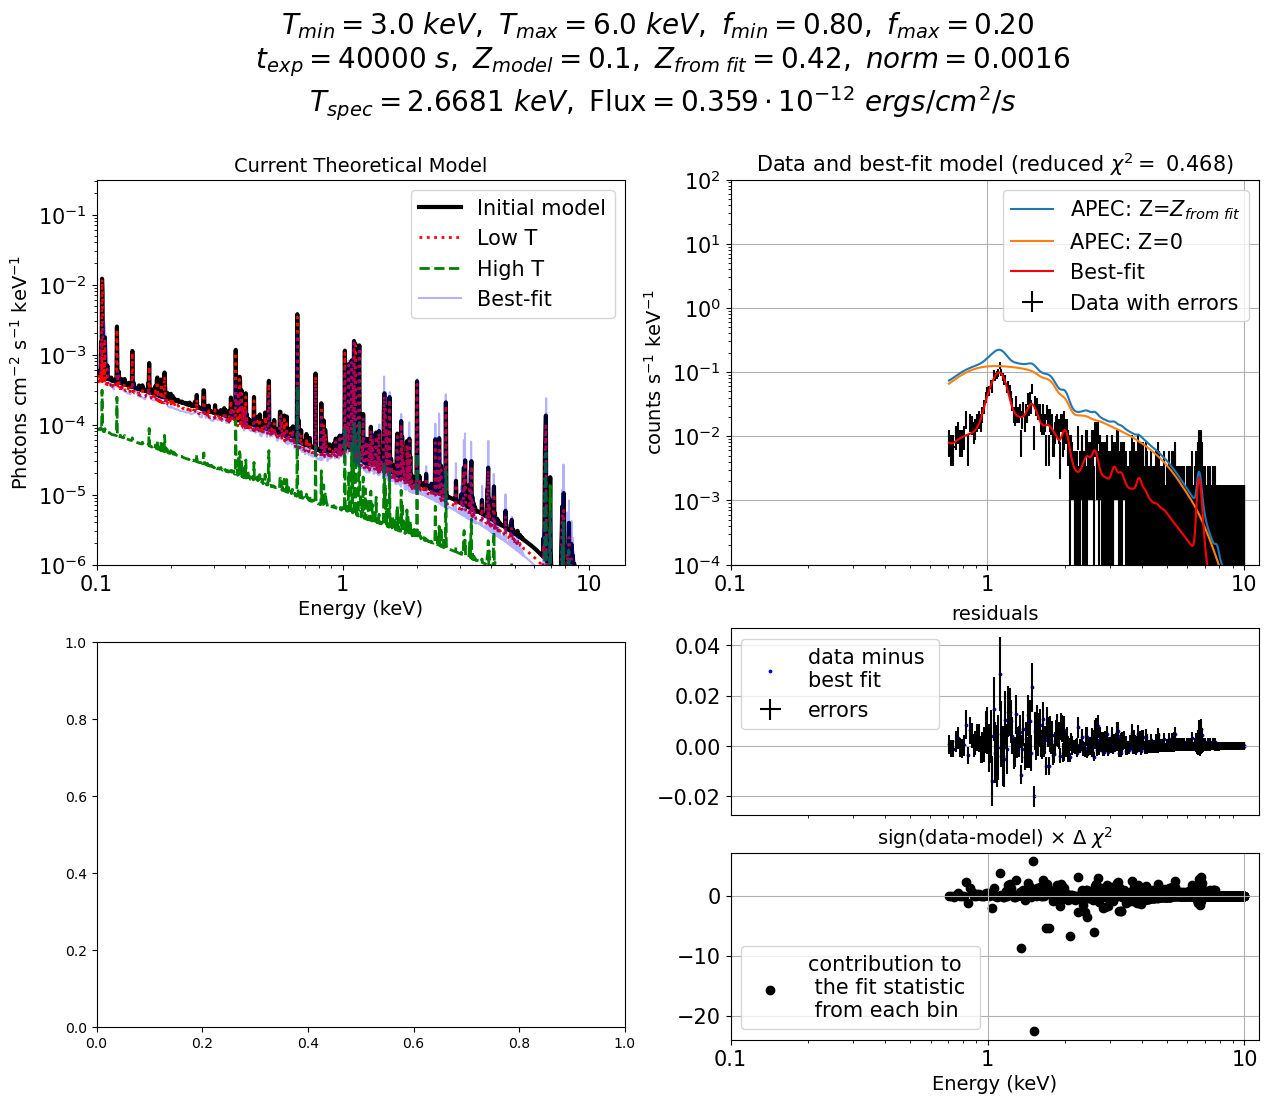

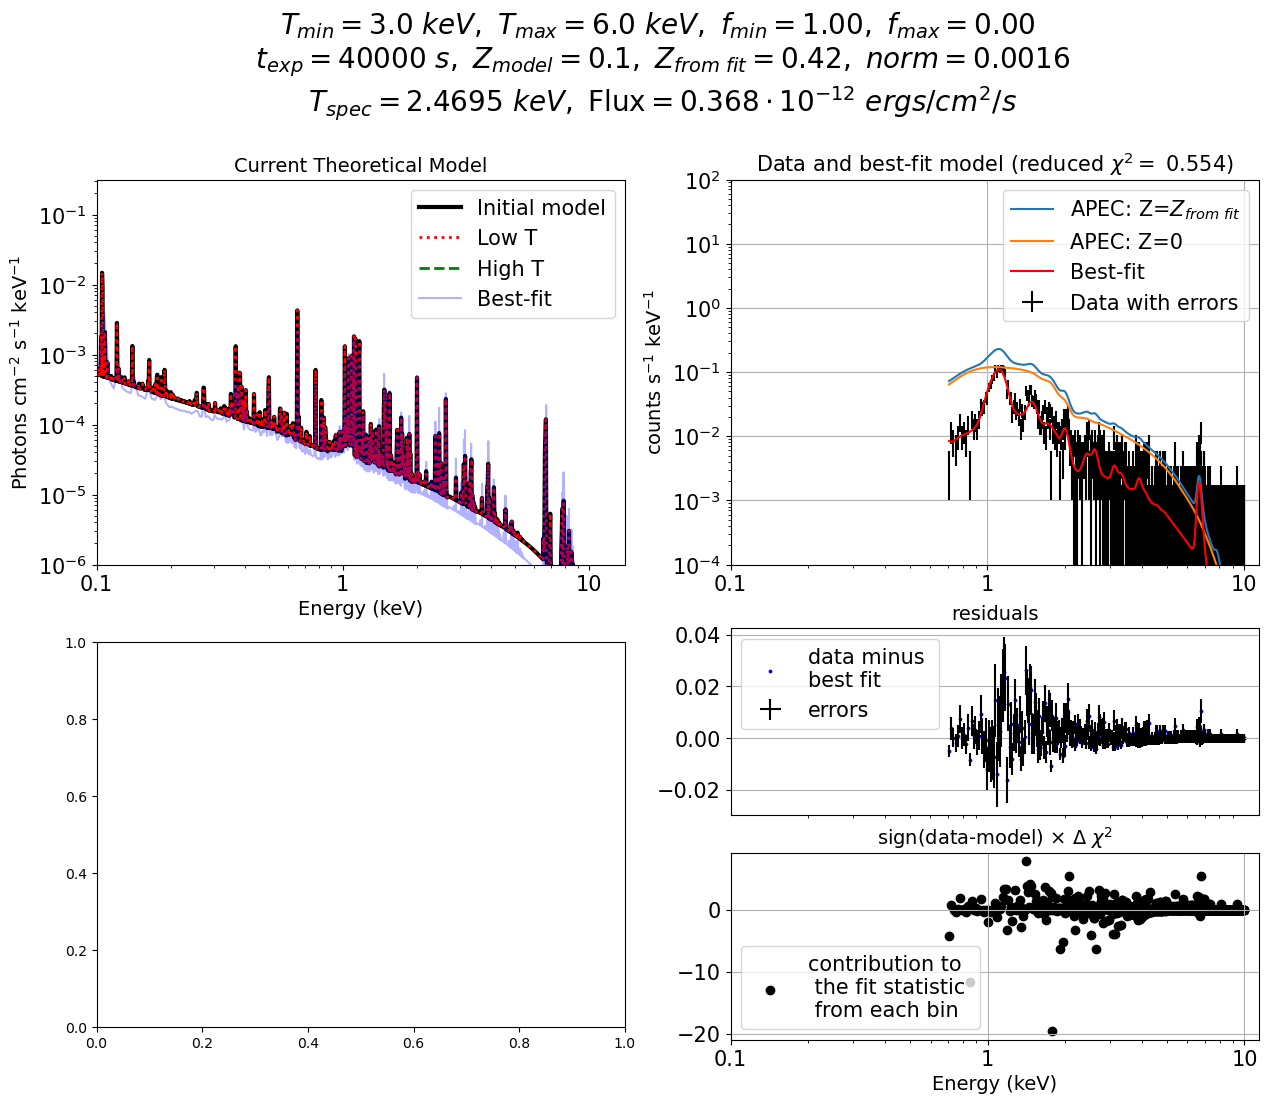

T:  [5.25485137739438, 3.8581719549274545, 3.3244868104301073, 2.9288272566653664, 2.6680737259513867, 2.469464048712215]
F:  [3.3230156448065974e-13, 3.3585517988411674e-13, 3.5326362402306483e-13, 3.3637453632169283e-13, 3.594250241350952e-13, 3.681688559258935e-13]
[]


In [509]:
logFile = x.Xset.openLog("newLogFile.txt")

%run -i 'utils/fit_lines.py'

fitlisttttt, fluxxxx, dt1, dt2 = single_T_fit_lines(3.0, 6.0, 6, 0.1, 
                                                    'Chandra/ACIS-OLD', 
                                                    nrm=0.01, 
                                                    texp=40000, 
                                                    stpar=False, 
                                                    plot=True, 
                                                    Xplot=False)
print("T: ", fitlisttttt)
print("F: ", fluxxxx)
print([(a, b) for a, b in zip(dt1, dt2)])

## Замечания и дополнения:

1) `churazov` weights - для слабых источников

2) [statistic](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node119.html), [steppar](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node86.html), [error](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node79.html), [error codes](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node60.html#tclouterror)

3) Калибровка через `cflux`

4) Добавить возможность менять $n_H$

5) Научиться добавлять фон: `background`

6) [Appendix B: Statistics in XSPEC](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node319.html#AppendixStatistics)

## 1.3 Figure 3

Вычисляем всё необходимое в PyXspec:

In [536]:
%run -i 'utils/ave_lines.py'
%run -i 'utils/fit_lines.py'

#telescope = 'Chandra/ACIS-OLD'
#telescope = 'XMM-Newton/MOS'
telescope = 'SRG/eROSITA'

T_mins = (0.25, 0.5, 1., 0.5, 1.0)
T_maxs = (0.5, 1.0, 2.0, 1.5, 3.0)

#Tspec_lines_fit = {}
Tspec_lines_from_avE = {}

Nfmins = 21

for T_min, T_max in list(zip(T_mins, T_maxs)):

   # Tspec_lines_fit[str(T_min)+'-'+str(T_max)] = single_T_fit_lines(T_min, T_max, Nfmins, 1.0, 
   #                                                                 telescope, nrm=1, texp=40000, 
   #                                                                 stpar=False, plot = False)[0]
    
    Tspec_lines_from_avE[str(T_min)+'-'+str(T_max)] = calc_Tspec_from_avE(T_min, T_max, Nfmins, telescope)
    
    print(str(T_min)+'-'+str(T_max)+": done")
    
#for key in Tspec_lines_all.keys():
#    print(key, 'keV')
#    print([f'{vl:.2f}' for vl in Tspec_lines_all[key]], '\n')

0.25-0.5: done
0.5-1.0: done
1.0-2.0: done
0.5-1.5: done
1.0-3.0: done


<Figure size 640x480 with 0 Axes>

Рисуем картинку:

In [ ]:
%run -i 'utils/ave_lines.py'
%run -i 'utils/fit_lines.py'

plt.figure(figsize=(17,8))
 
plt.suptitle('\n' + 'Line-dominated spectra (' + telescope + ')', fontsize = 20)

plt.subplot(1,2,1)

T_mins = (0.25, 0.5, 1.)
T_maxs = (0.5, 1.0, 2.0)

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # mean energy
    plt.plot(np.linspace(0, 1, Nfmins), 
             Tspec_lines_from_avE[str(T_min)+'-'+str(T_max)], linestyle='-', color='blue')
    
    # naive
    plt.plot(np.linspace(0, 1, Nfmins), [fmin*T_min+(1-fmin)*T_max for fmin in np.linspace(0, 1, Nfmins)], 
             linestyle = '--', linewidth=2, color='black')
    
    # direct fit
    plt.scatter(np.linspace(0, 1, Nfmins), Tspec_lines_fit[str(T_min)+'-'+str(T_max)])
    
    plot_Tspec_fmin_details()
    
    #plt.plot(np.linspace(0, 1, len(Tspec_list)), Tspec_list, color='black', linewidth=1)
    
plt.ylim(0, 2.3)

    
plt.subplot(1,2,2)

T_mins = (0.5, 1.0)
T_maxs = (1.5, 3.0)

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # mean energy
    plt.plot(np.linspace(0, 1, Nfmins), 
             Tspec_lines_from_avE[str(T_min)+'-'+str(T_max)], linestyle='-', color='blue')
    
    # naive
    plt.plot(np.linspace(0, 1, Nfmins), [fmin*T_min+(1-fmin)*T_max for fmin in np.linspace(0, 1, Nfmins)], 
             linestyle = '--', linewidth=2, color='black')
    
    # direct fit
    plt.scatter(np.linspace(0, 1, Nfmins), Tspec_lines_fit[str(T_min)+'-'+str(T_max)])
    
    plot_Tspec_fmin_details()
    plt.ylim(0, 3.3)
    
plt.show()

# 2. CONTINUUM ONLY

To show list of `xspec` commands use `x.Plot.commands`.
If something is not plotting, try `x.Plot.commands=()`.

## 2.1 $T_{spec}$ from direct fit

### Mazotta-like fit
Single-T fit for mixture of 2 continuums (now working properly):

<Figure size 640x480 with 0 Axes>

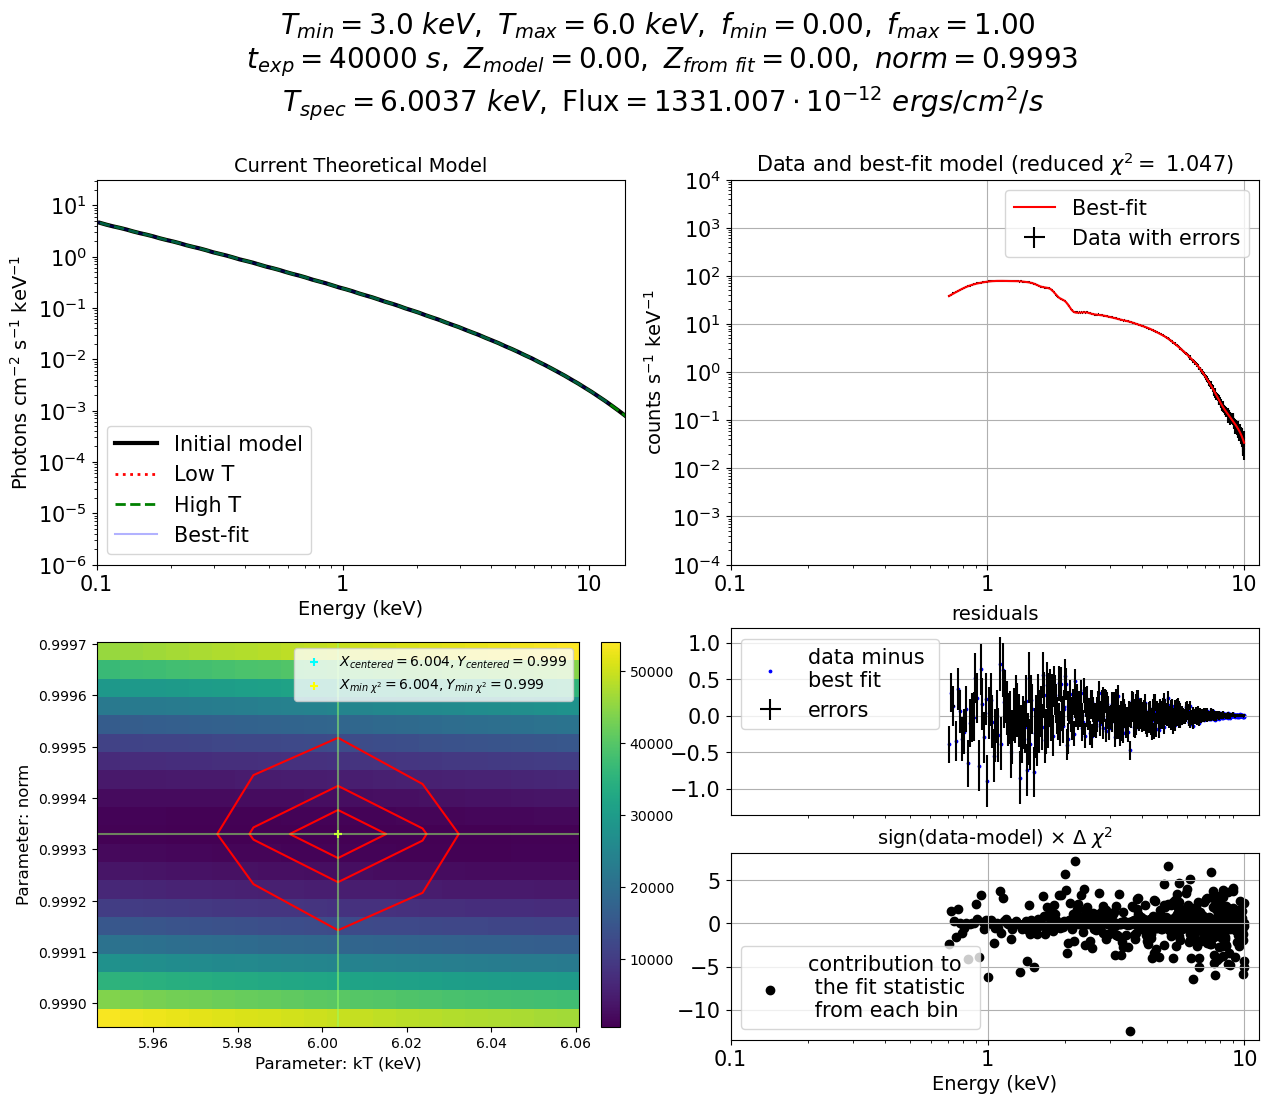

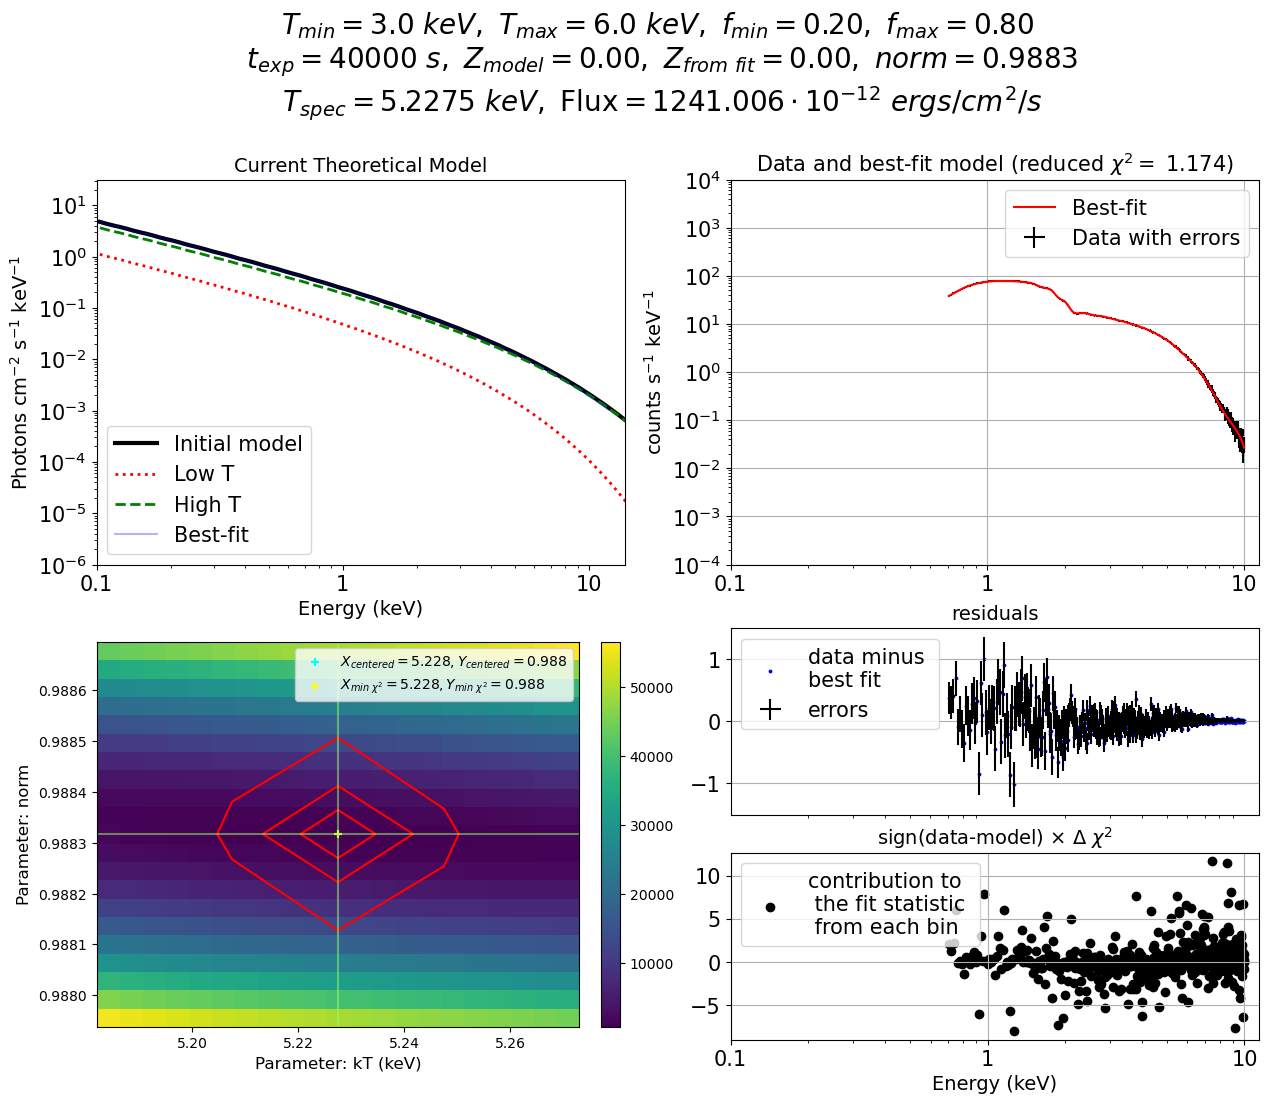

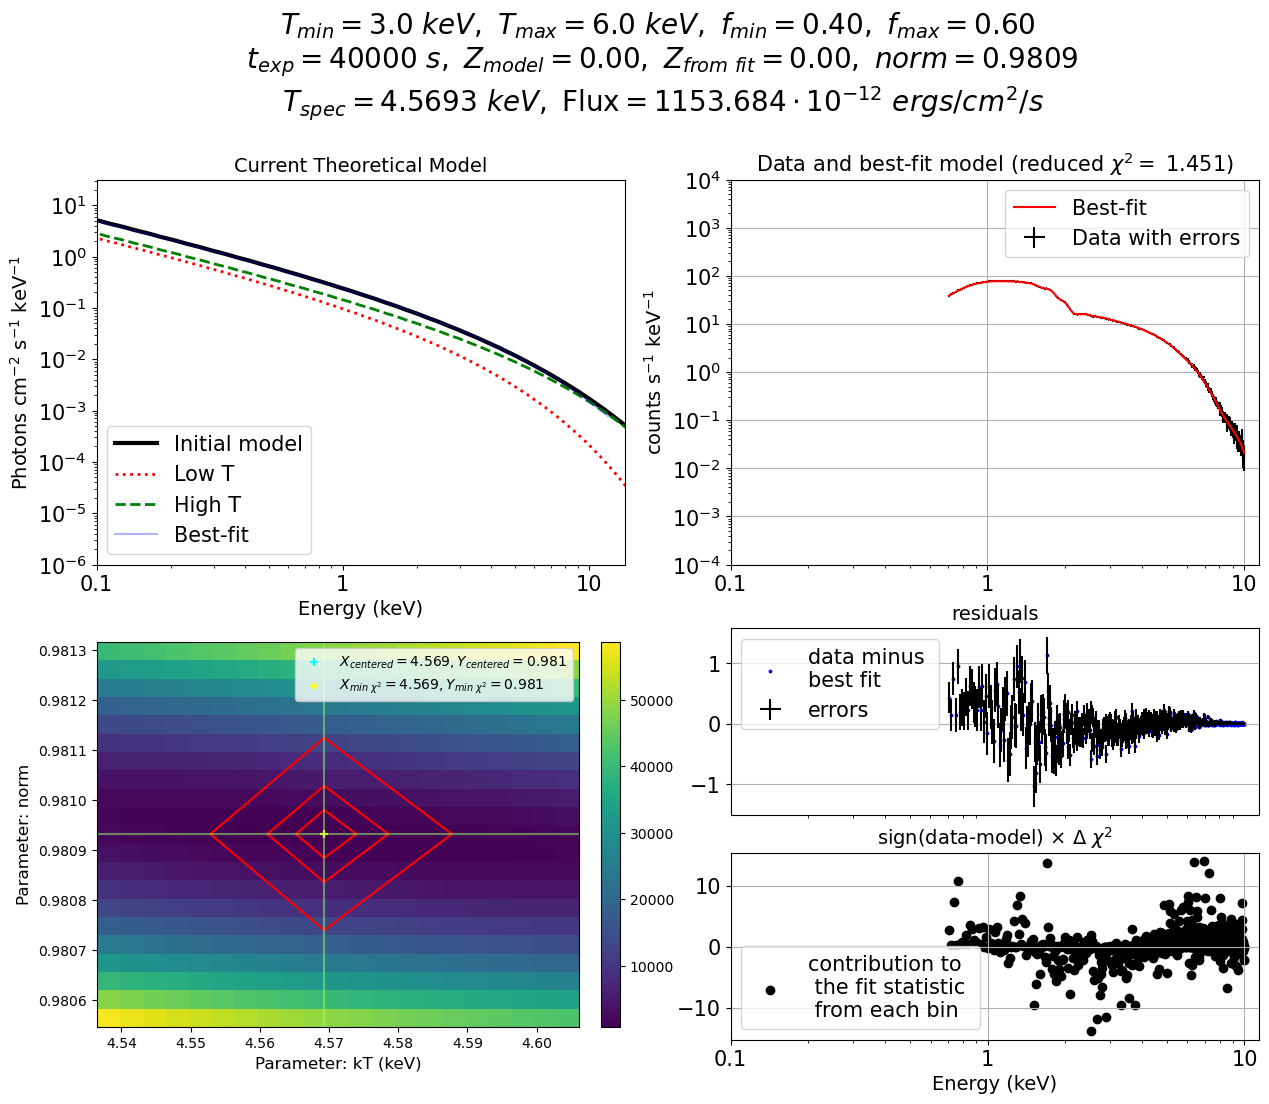

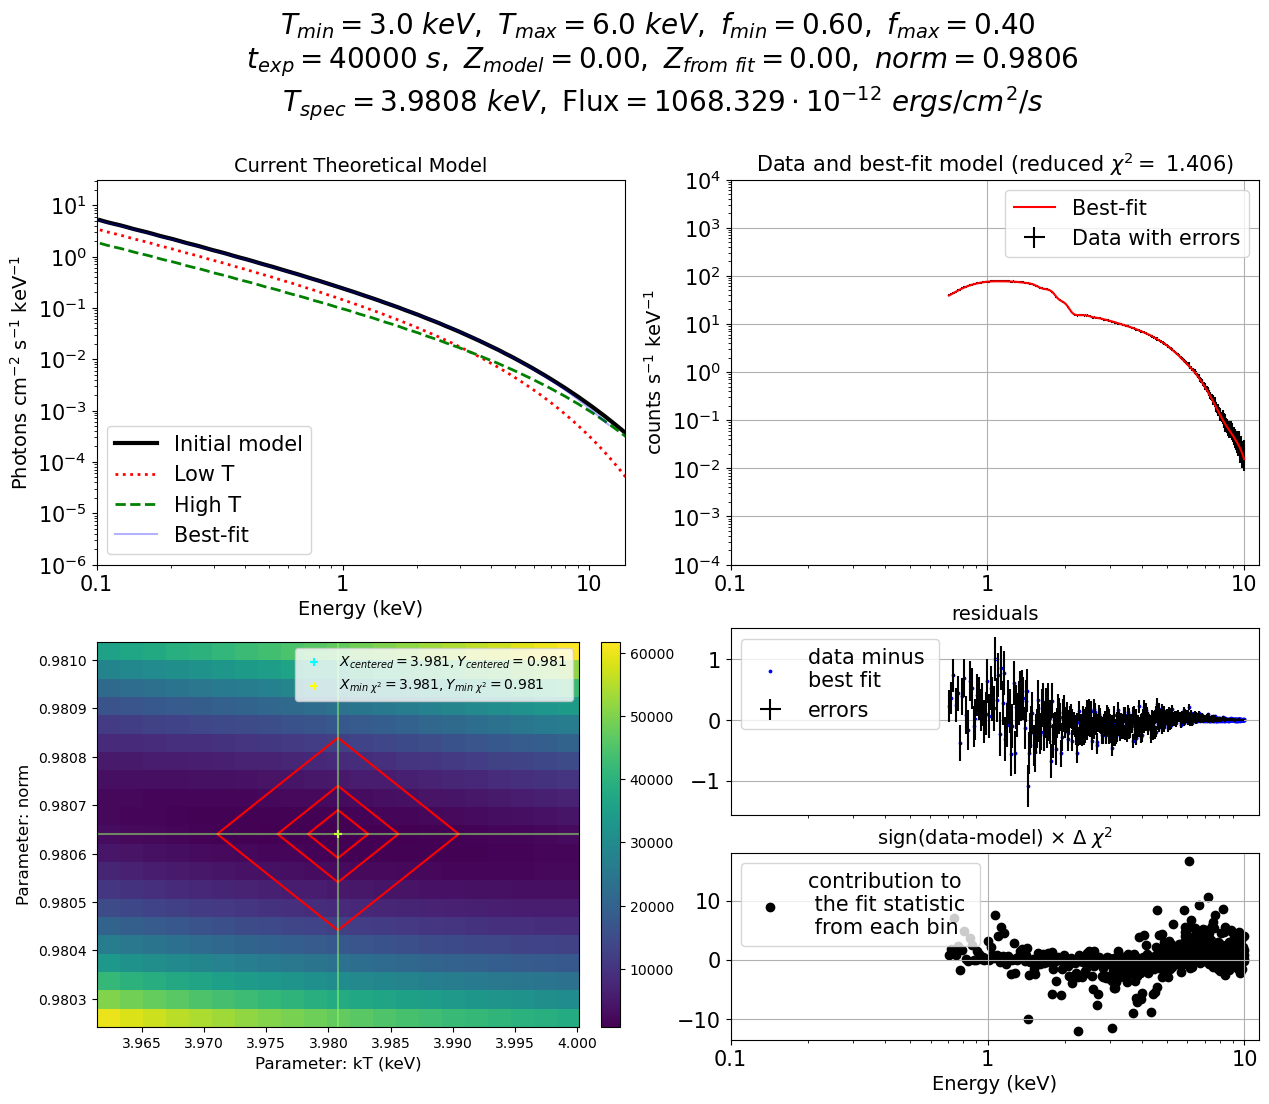

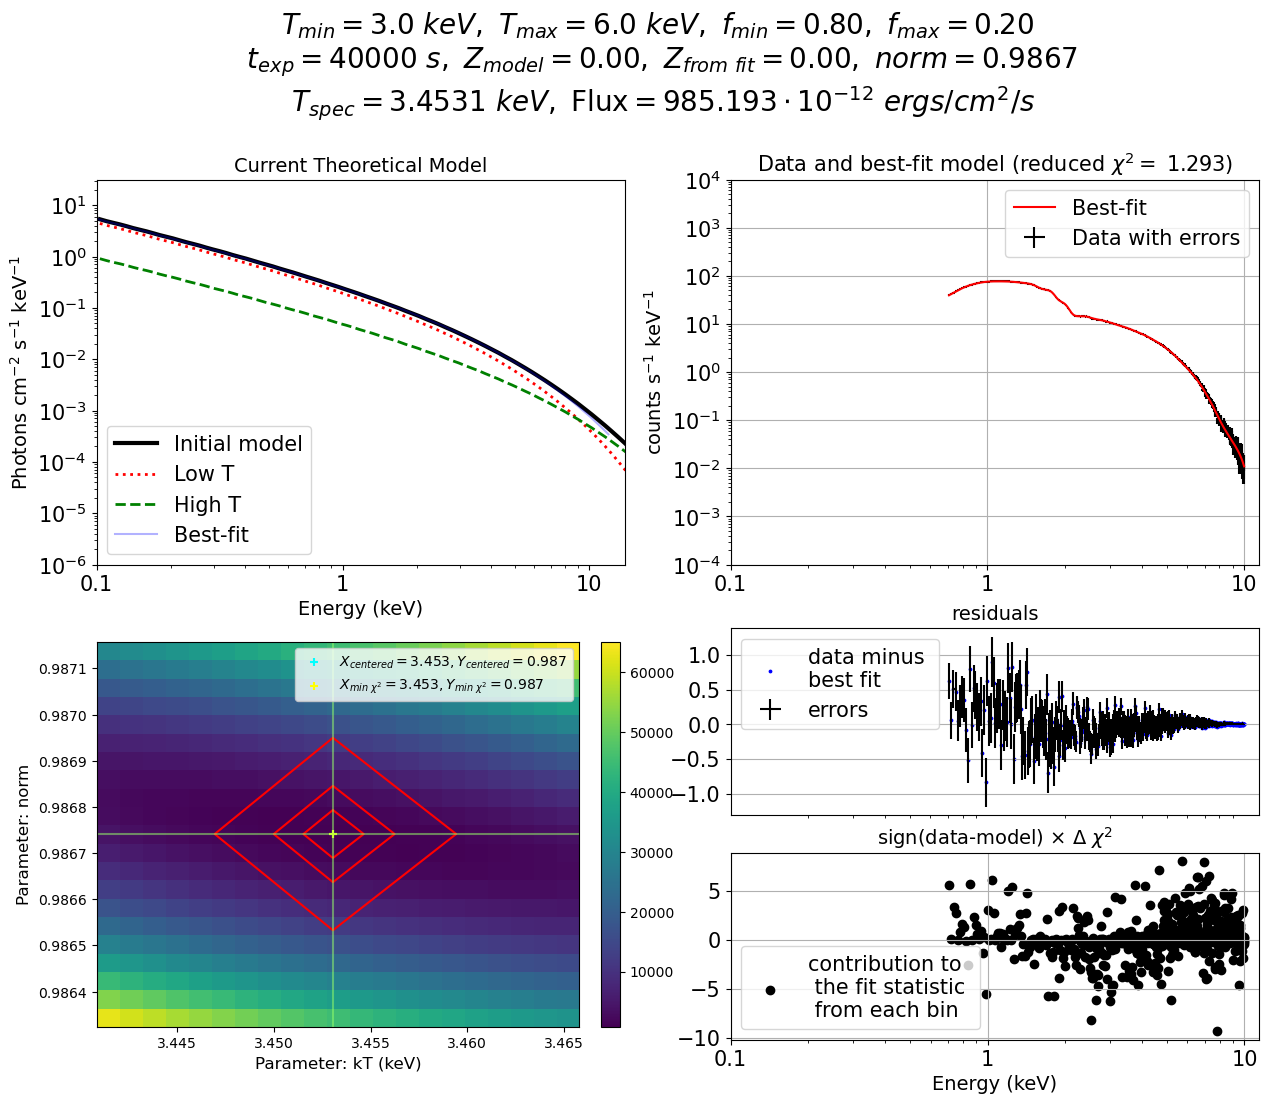

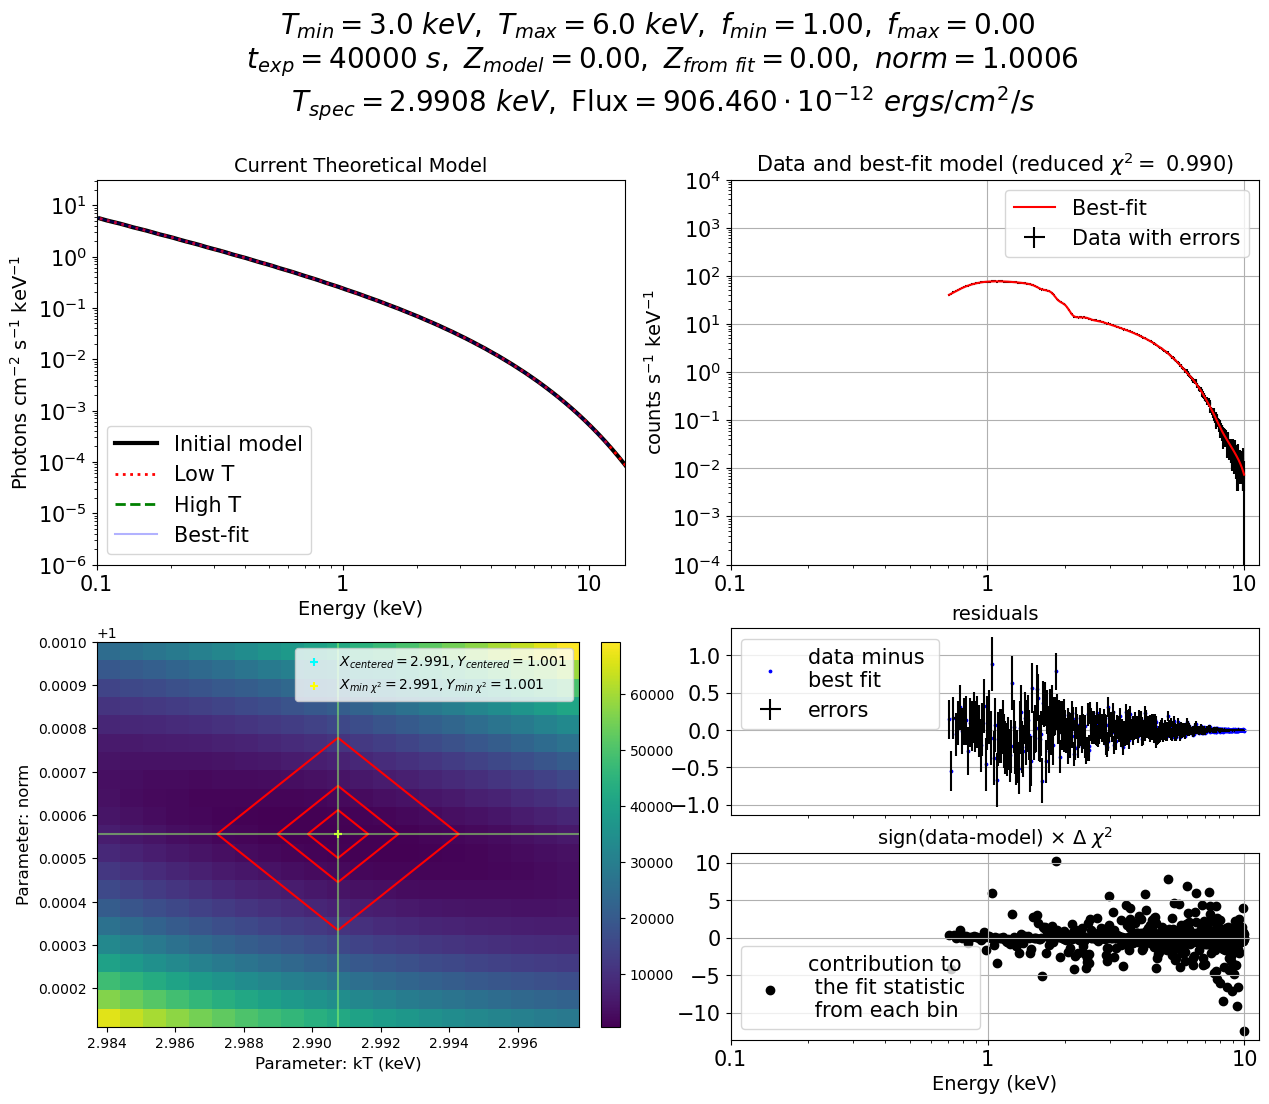

T:  [6.003738229280778, 5.227545787191951, 4.569313469287765, 3.9807668557075258, 3.453050780941084, 2.9907571997614553]
F:  [1.3310066850906821e-09, 1.241006335232557e-09, 1.1536838007357987e-09, 1.0683287670168536e-09, 9.851933920434841e-10, 9.064603461920394e-10]
[]


In [523]:
logFile = x.Xset.openLog("newLogFile.txt")

%run -i 'utils/fit_cont.py'
    
ccc, fluxccc, dt1_cont, dt2_cont = single_T_fit_continuum(3.0, 6.0, 6, 
                                                          'Chandra/ACIS-OLD', 
                                                          nrm=1, 
                                                          texp=40000, 
                                                          stpar=True, 
                                                          plot=True, 
                                                          Xplot=False)
print("T: ", ccc)
print("F: ", fluxccc)
print([(a, b) for a, b in zip(dt1_cont, dt2_cont)])

## 2.2 $T_{spec}$ from weighting

In [ ]:
%run -i 'utils/avt_cont.py'

## 2.3 Figure 4

Вычисляем всё необходимое:

In [5]:
%run -i 'utils/avt_cont.py'
%run -i 'utils/fit_cont.py'

telescope, alpha_current = 'Chandra/ACIS-OLD', 0.86
#telescope, alpha_current = 'XMM-Newton/MOS', 0.900
#telescope, alpha_current = 'SRG/eROSITA', 1.09

print(alpha_current)

f_min = np.linspace(0, 1, 21)
T_spec = f_min*0

T_mins = (0.25, 0.5, 1.0, 2.0, 4.0)
T_maxs = (1.0,  2.0, 4.0, 8.0, 16.0)

Tspec_from_eq46 = {}
Tspec_from_fit ={}

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # Tspec from equations 4, 6
    #Tspec_from_eq46[str(T_min)+'-'+str(T_max)] = get_Tspec_continuum_eq46(f_min, T_min, T_max, alpha_current, telescope)
    
    # Tspec from direct fit
    Tspec_from_fit[str(T_min)+'-'+str(T_max)] = single_T_fit_continuum(T_min, T_max, len(f_min), 
                                                                       telescope, 1, 40000, 
                                                                       stpar=False, plot=False, Xplot=False)[0]
    
    print(str(T_min)+'-'+str(T_max)+": done")
    
#for key in Tspec_from_eq46.keys():
#    print(key, 'keV')
#    print('Eqs. 4, 6:', [f'{vl:.2f}' for vl in Tspec_from_eq46[key]], '\n')
#    print('Direct fit', [f'{vl:.2f}' for vl in Tspec_from_fit[key]], '\n')

0.86
0.25-1.0: done
0.5-2.0: done
1.0-4.0: done
2.0-8.0: done
4.0-16.0: done


<Figure size 640x480 with 0 Axes>

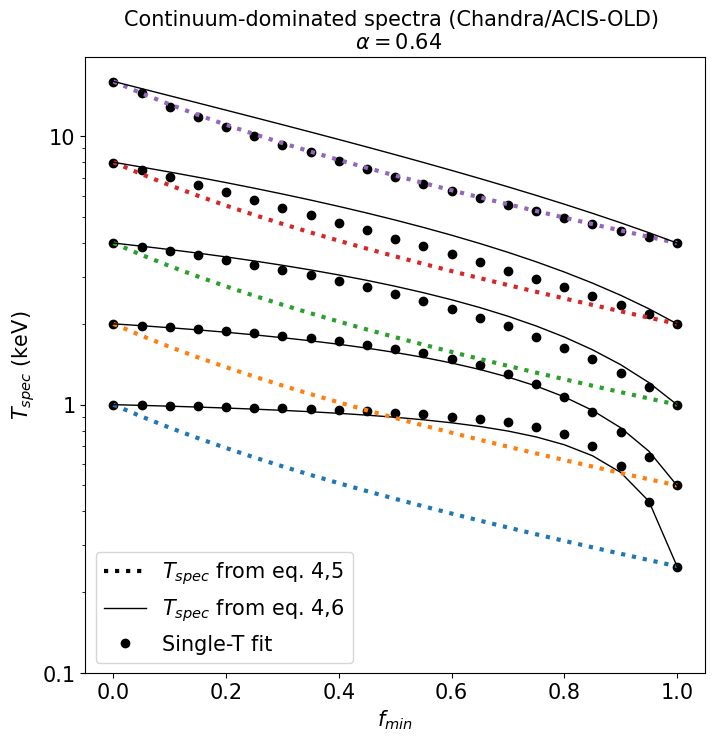

In [10]:
%run -i 'utils/avt_cont.py'
%run -i 'utils/fit_cont.py'

plt.figure(figsize=(8,8))

alpha_current = 0.64

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # naive weighting
    #plt.plot(f_min, f_min*T_min+(1-f_min)*T_max, linestyle = '--', linewidth=2, color='black')
    
    # Tspec from equations 4, 5
    plt.plot(f_min, get_Tspec_continuum_eq45(f_min, T_min, T_max), linestyle = ':', linewidth = 3)

    # Tspec from equations 4, 6
    plt.plot(f_min, get_Tspec_continuum_eq46(f_min, T_min, T_max, alpha_current, 
                                             telescope), color='black', linewidth=1)
    
    # Tspec from direct fit
    Tspec_list1 = Tspec_from_fit[str(T_min)+'-'+str(T_max)]
    plt.scatter(f_min, Tspec_list1, color='black')
    
#plt.scatter(np.linspace(0, 1, len(T_spec)), T_spec, color='blue')   
    
fancy_fig4()

plt.show()

## 2.4 Searching for $\alpha_{min}$

Let's try to find the value of $\alpha$ at which $T_{sl}$ from equations 4,6 is the closest to $T_{spec}$ from direct fit. Observations by SRG/eROSITA and also by Chandra are considered. See eq. (13) from Mazzotta et al. (2004): https://arxiv.org/pdf/astro-ph/0404425.pdf

$\Delta=\frac{1}{N} \sum_{T_1, T_2} \sqrt{\left(\frac{T_{\mathrm{sl}} - T_{\mathrm{spec}}}{T_{\mathrm{spec}}}\right)^2}$

In [16]:
%run -i 'utils/avt_cont.py'
%run -i 'utils/fit_cont.py'

#telescope = 'Chandra/ACIS-OLD' 
#telescope = 'SRG/eROSITA'
#telescope = 'XMM-Newton/MOS'

print(telescope)

deltas = []
alphas = np.linspace(0.500, 1.200, 11)

f_min = np.linspace(0, 1, 21)

for a in alphas:

    delta_sum = 0
    N_deltasum = 0

    T_mins = (0.25, 0.5, 1.0, 2.0, 4.0)
    T_maxs = (1.0,  2.0, 4.0, 8.0, 16.0)

    #T_mins = (0.5, 1., 2., 3., 0.5, 1., 2., 3., 0.5, 1., 2., 3.)
    #T_maxs = (1. , 2., 4., 6., 1.5, 3., 6., 9., 2. , 4., 8., 12.)
    
    Delta_fin = 0
#    NDeltas = 5
    
#    for i in range(0, NDeltas):
        
    for T_min, T_max in list(zip(T_mins, T_maxs)):

        # Tspec from equations 4, 6
        T_sl = get_Tspec_continuum_eq46(f_min, T_min, T_max, a, telescope)

        # Tspec from direct fit
        #T_spec = single_T_fit_continuum(T_min, T_max, len(f_min), telescope, nrm=1, 
        #                                texp=40000, stpar=False, plot=False, Xplot=False)[0]
        T_spec = Tspec_from_fit[str(T_min)+'-'+str(T_max)]


        difference = [Ta-Tb for Ta, Tb in zip(T_sl, T_spec)]
        terms = [num/denom for num, denom in zip(difference, T_spec)]
        terms2 = [t**2 for t in terms]
        sqrterms2 = [np.sqrt(tt) for tt in terms2]
        delta_term = np.sum(sqrterms2)
        delta_sum = delta_sum + delta_term
        N_deltasum = N_deltasum + len(f_min)
        print(N_deltasum, end=" ")

    Delta_fin = delta_sum/N_deltasum

#        Delta_fin +=Delta/NDeltas
        
    print(a, Delta_fin)

    deltas.append(Delta_fin)

Chandra/ACIS-OLD
21 42 63 84 105 0.5 0.04202224872432245
21 42 63 84 105 0.57 0.03754361880759144
21 42 63 84 105 0.64 0.0370754275509886
21 42 63 84 105 0.71 0.04073243481250478
21 42 63 84 105 0.78 0.04990718302843811
21 42 63 84 105 0.85 0.06277322869836738
21 42 63 84 105 0.9199999999999999 0.07974724430675303
21 42 63 84 105 0.99 0.09654786463994605
21 42 63 84 105 1.06 0.11302729082450255
21 42 63 84 105 1.13 0.12917031763955006
21 42 63 84 105 1.2 0.14496330021516476


<Figure size 640x480 with 0 Axes>

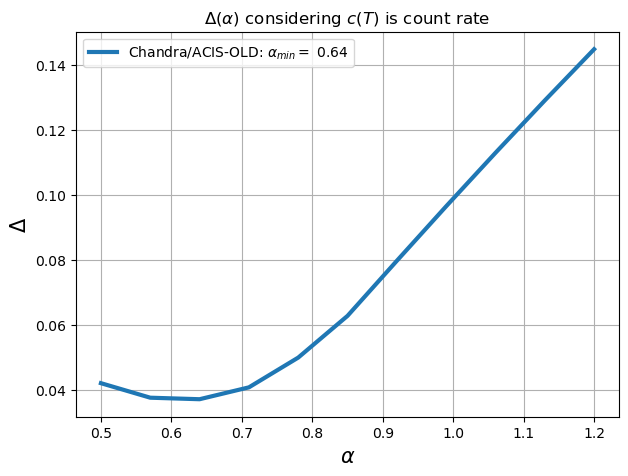

In [17]:
if telescope == 'Chandra/ACIS-OLD': 
    alphas_CH = alphas
    deltas_CH = deltas
elif telescope == 'SRG/eROSITA':
    alphas_ER = alphas
    deltas_ER = deltas
elif telescope == 'XMM-Newton/MOS':
    alphas_XN = alphas
    deltas_XN = deltas

plt.figure(figsize=(7,5))

plt.plot(alphas_CH, deltas_CH, linewidth=3, label=f'Chandra/ACIS-OLD: $\\alpha_{{min}} =$ {alphas_CH[np.argmin(deltas_CH)]:.2f}')
#plt.plot(alphas_XN, deltas_XN, linewidth=3, label=f'XMM-Newton/MOS: $\\alpha_{{min}} =$ {alphas_XN[np.argmin(deltas_XN)]:.2f}')
#plt.plot(alphas_ER, deltas_ER, linewidth=3, label=f'SRG/eROSITA: $\\alpha_{{min}} =$ {alphas_ER[np.argmin(deltas_ER)]:.2f}')

#plt.plot(alphas, deltas, linewidth=3, label=f'{telescope}: $\\alpha_{{min}} =$ {alphas[np.argmin(deltas)]:.2f}')
plt.xlabel('$\\alpha$', fontsize=15)
plt.ylabel('$\\Delta$', fontsize=15)#, rotation = 'horizontal')
plt.title('$\Delta(\\alpha)$ considering $c(T)$ is count rate')
#plt.ylim(0, 0.07)
plt.legend()
plt.grid()
#plt.savefig('delta_alpha_ER.png')
plt.show()

We can see that $\Delta$ reaches its minimum at $\alpha=0.73$ (for SRG/eROSITA observations). 

# 3. REALISTIC METALLICITIES

## 3.1 $T_{spec}$ from direct fit

<Figure size 640x480 with 0 Axes>

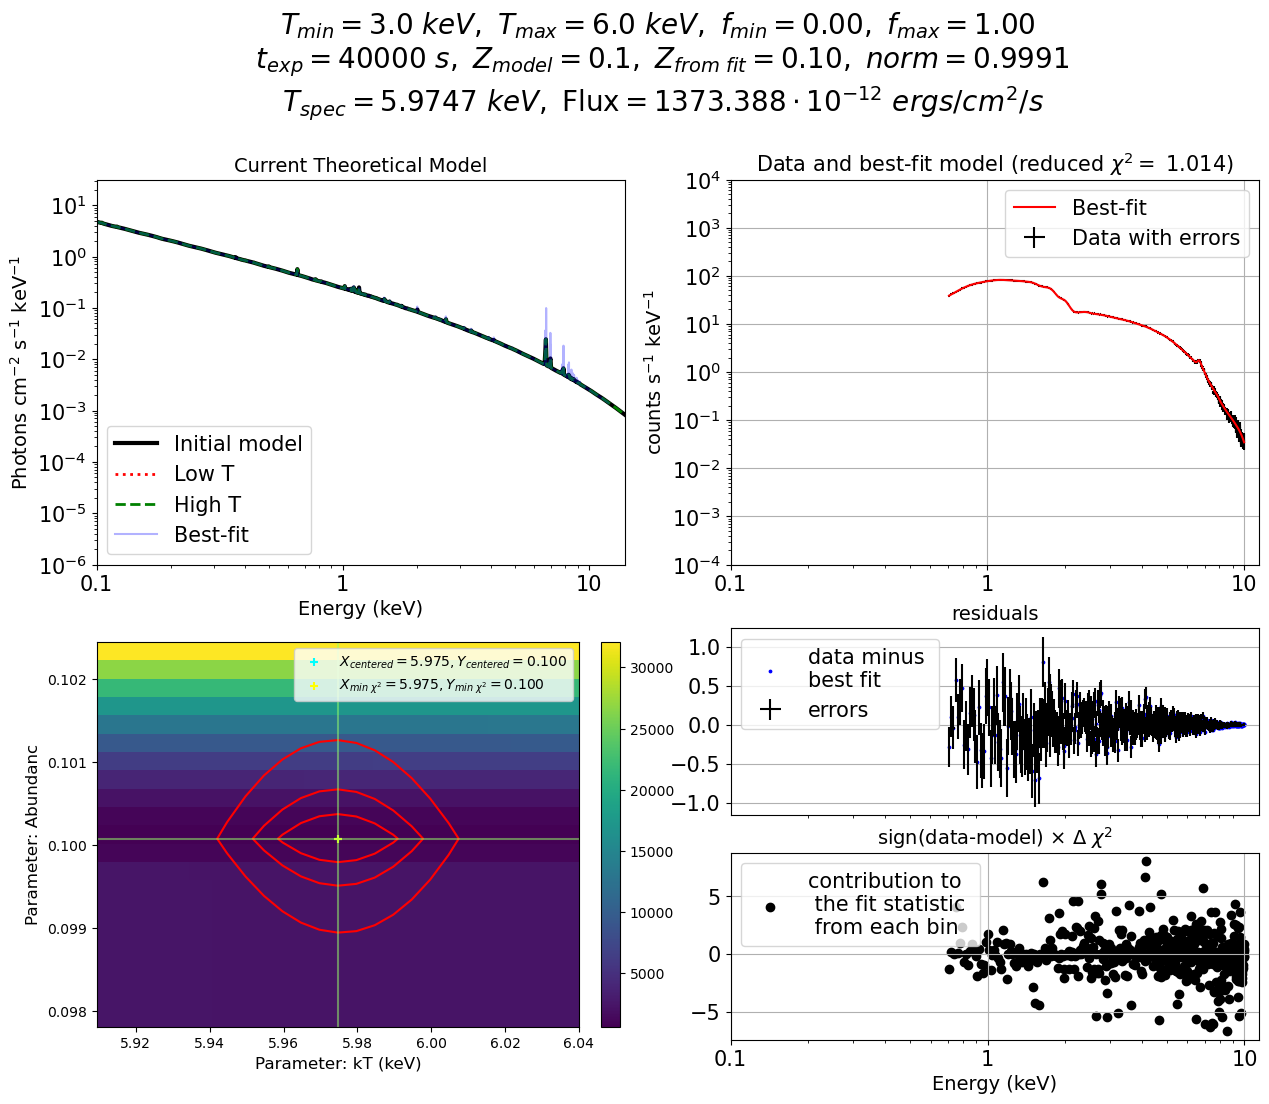

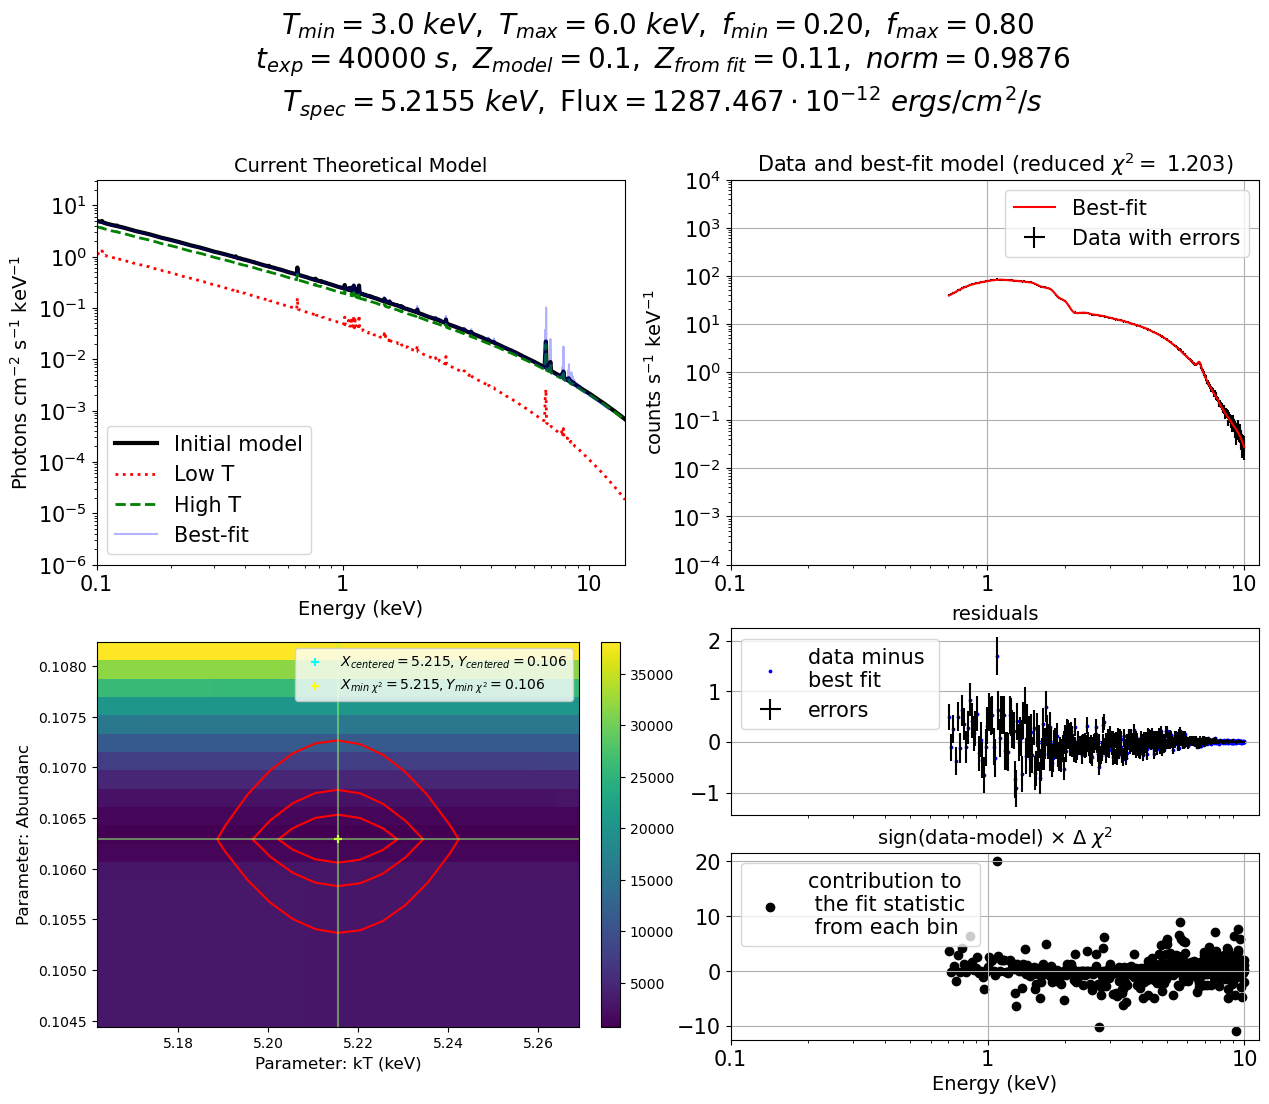

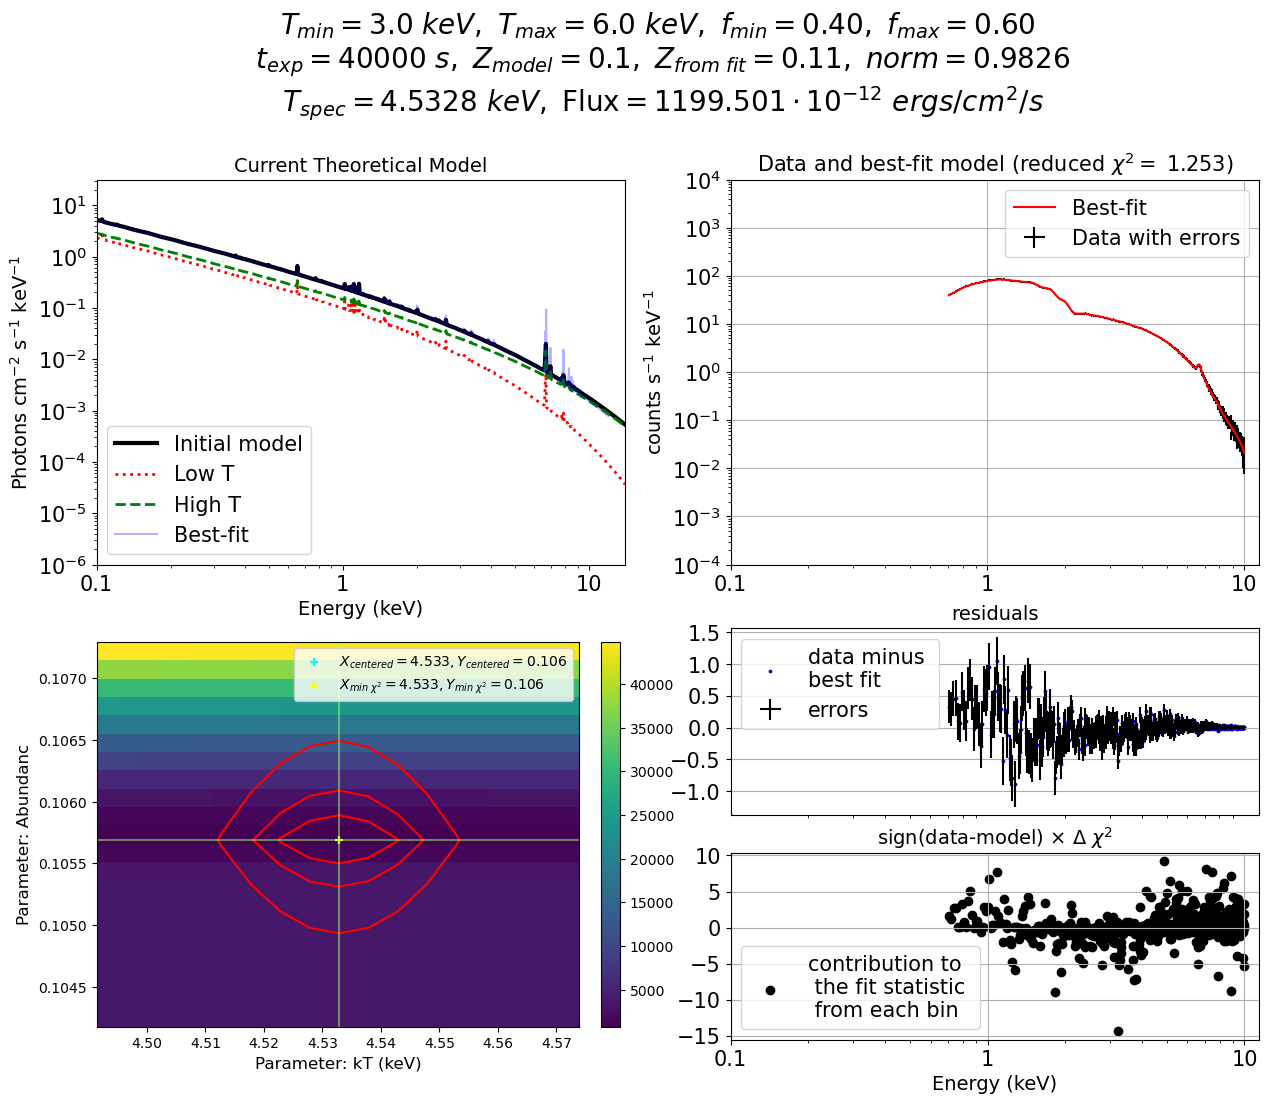

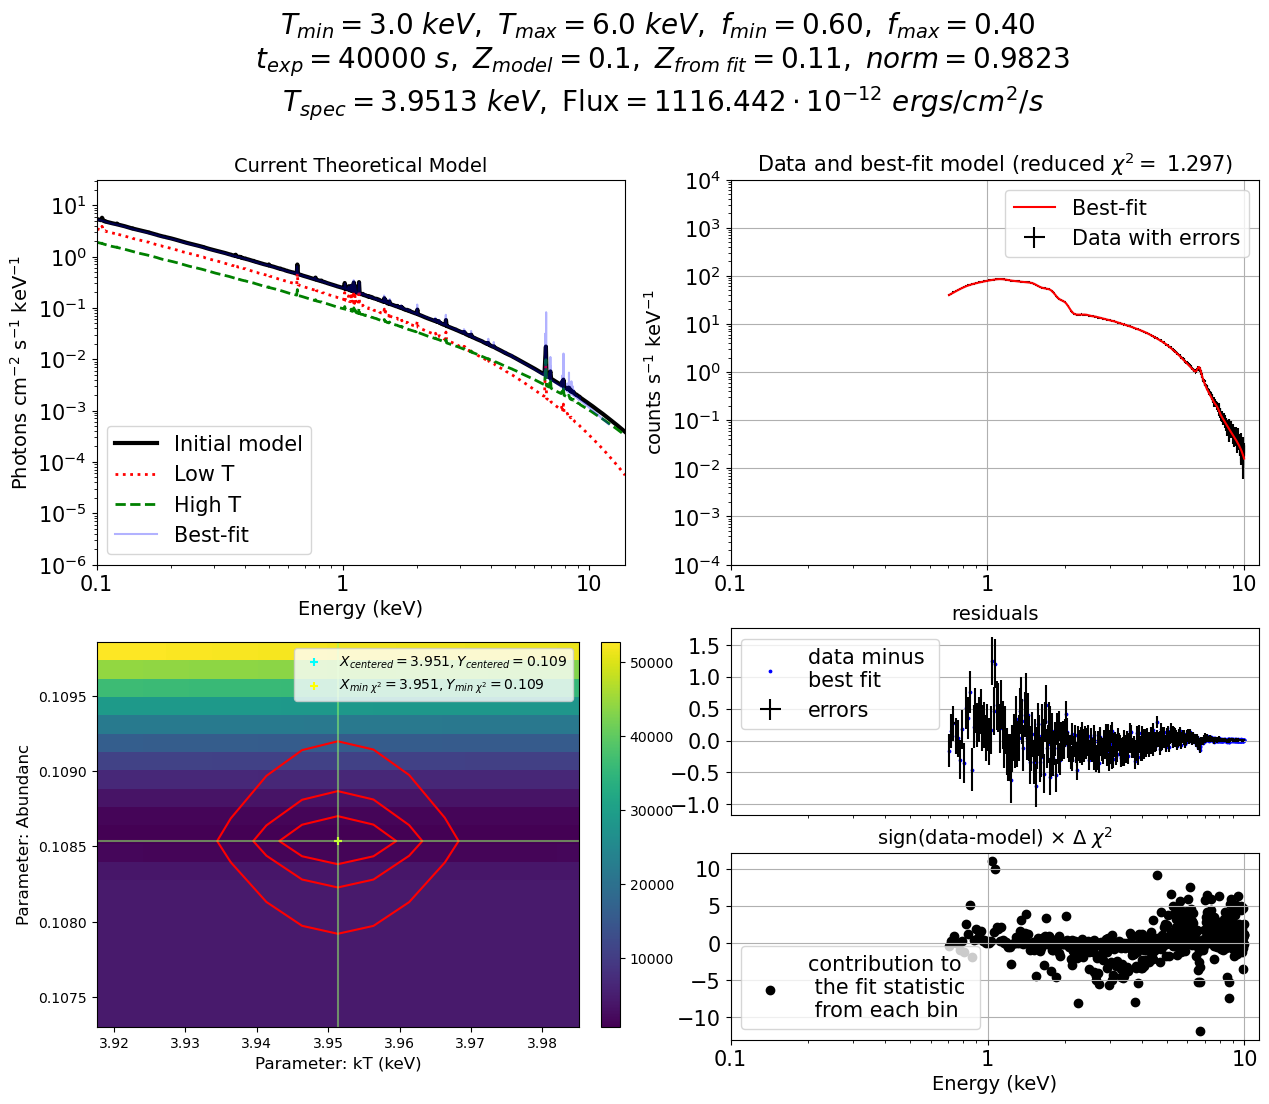

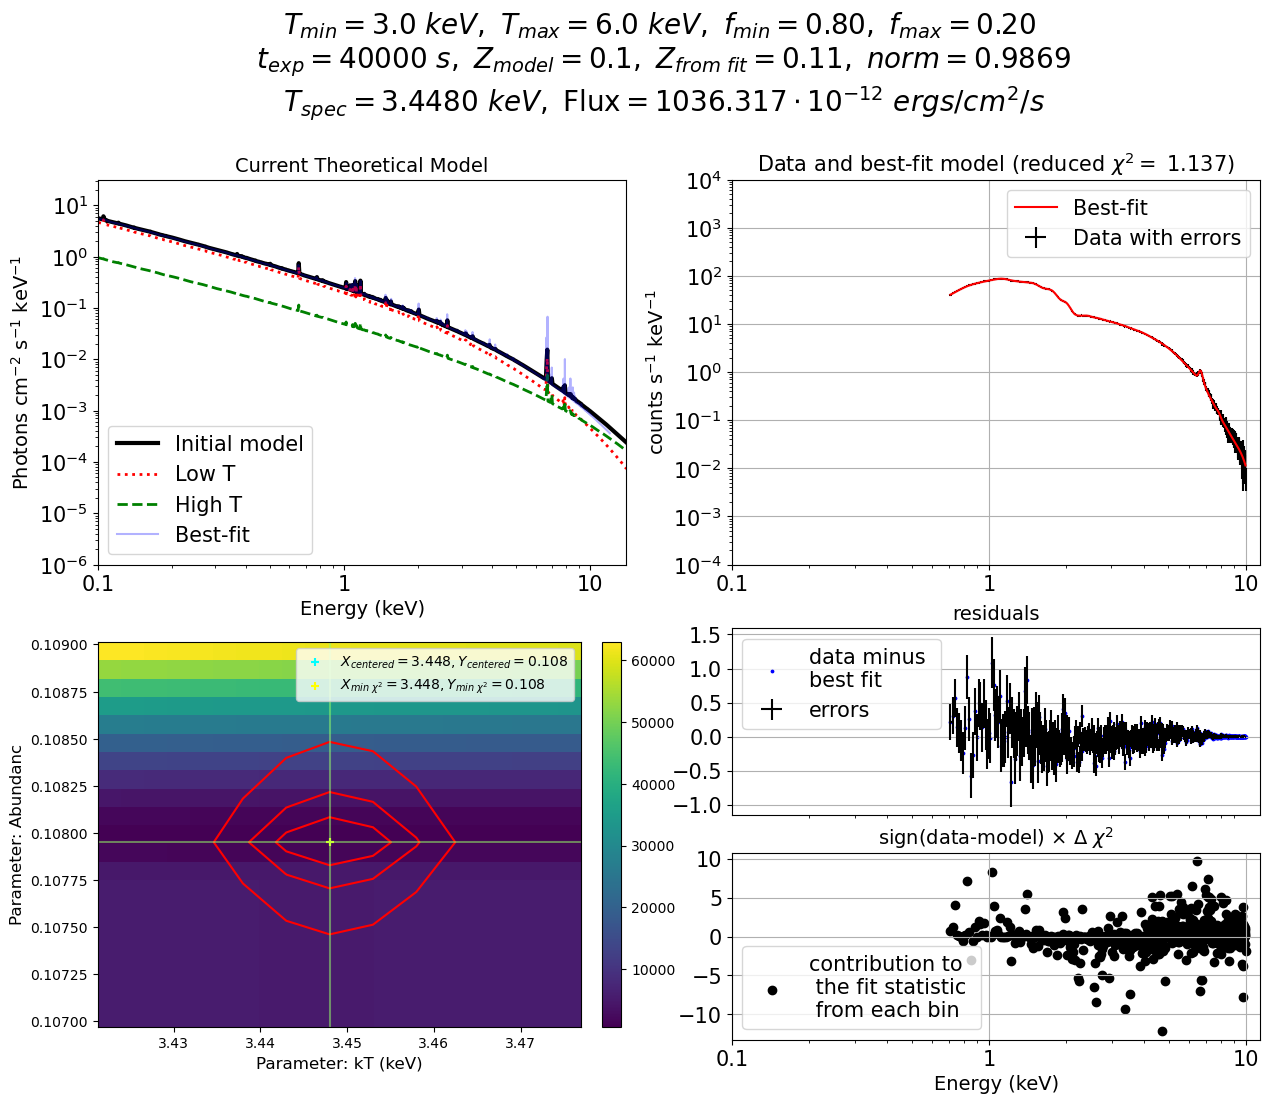

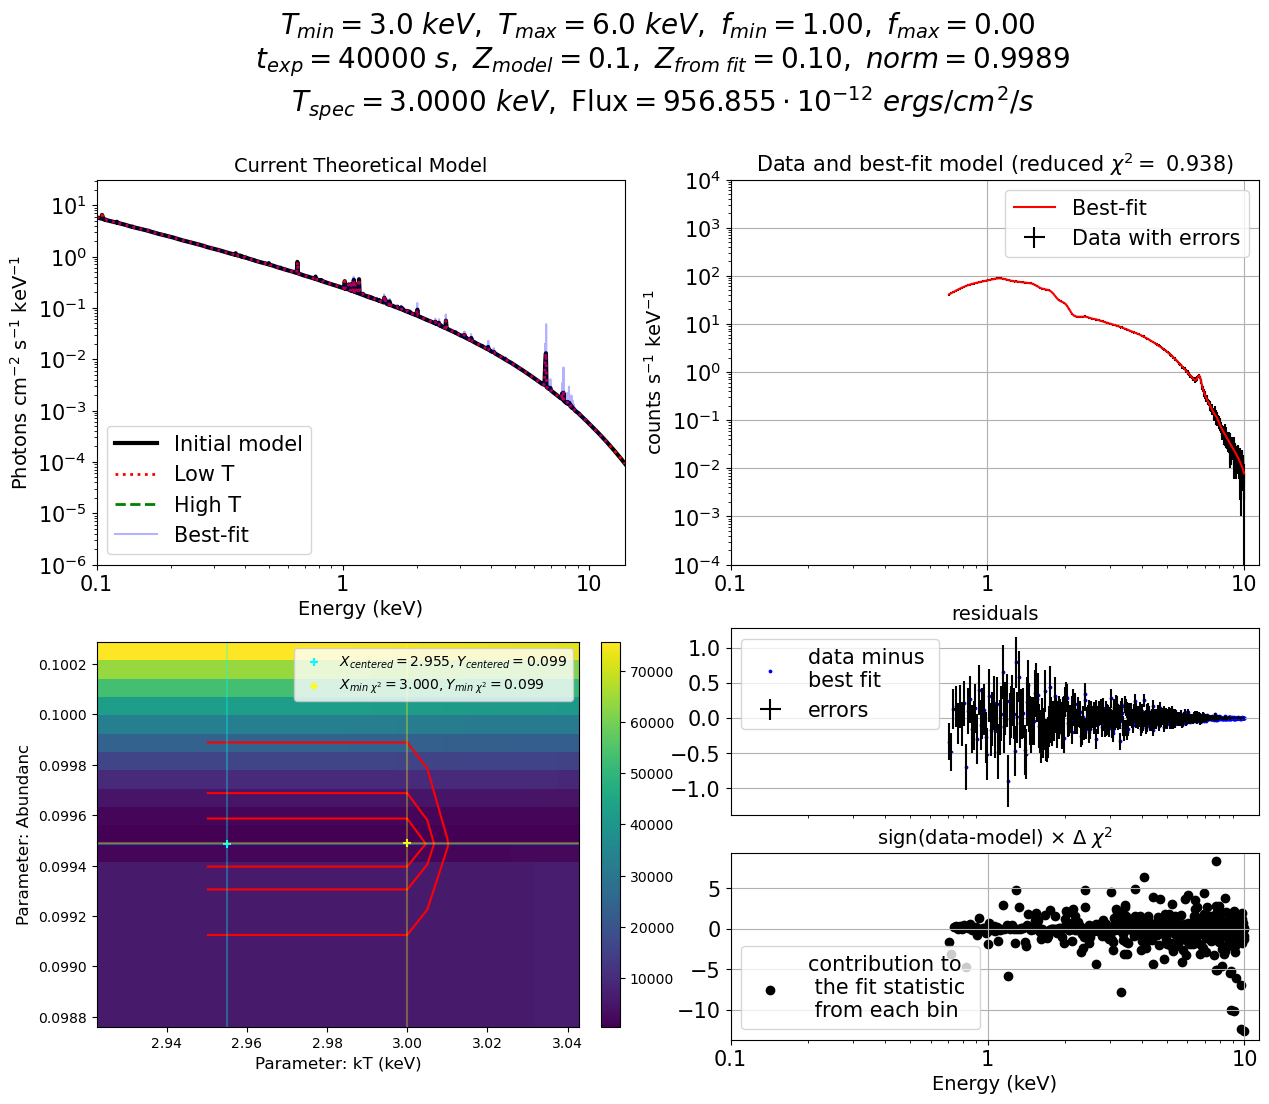

T:  [5.974718319691964, 5.215491382451657, 4.53284505779735, 3.9513412270048094, 3.4479707312597268, 3.0]
F:  [1.3733881818141799e-09, 1.287467275084448e-09, 1.1995009182424284e-09, 1.1164416157612686e-09, 1.0363171853224068e-09, 9.568546235304093e-10]
[]


In [511]:
logFile = x.Xset.openLog("newLogFile.txt")

%run -i 'utils/fit_reals.py'
    
aaa, aaa1, dt1_lft, dt1_rght = single_T_realistic(3.0, 6.0, 6, 0.1, 
                                                  'Chandra/ACIS-OLD', 
                                                  nrm=1, 
                                                  texp=40000,
                                                  bnds=[(3.,12.)]*6,
                                                  stpar=True, 
                                                  plot=True, 
                                                  Xplot=False)
print("T: ", aaa)
print("F: ", aaa1)
print([(a, b) for a, b in zip(dt1_lft, dt1_rght)])

## 3.2 Figure 5

In [9]:
logFile = x.Xset.openLog("newLogFile.txt")

%run -i 'utils/fit_lines.py'
%run -i 'utils/fit_cont.py'
%run -i 'utils/fit_reals.py'

%run -i 'utils/fit_main.py'
%run -i 'utils/ave_lines.py'
%run -i 'utils/avt_cont.py'

telescope = 'Chandra/ACIS-OLD' 
#telescope = 'SRG/eROSITA'
#telescope = 'XMM-Newton/MOS'

f_min = np.linspace(0, 1, 21)
T_spec = f_min*0

T_mins = (1.0, 2.0)
T_maxs = (3.0, 6.0)

Tspec_cont_fit_fig5 = {}
Tspec_lines_fit_fig5 = {}
single_T_fit_fig5 = {}

exxxpo = 40000
normmmm = 1

do_average = False

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    if do_average:
        
        Tsum_real = np.zeros(len(f_min))
        Tsum_cont = np.zeros(len(f_min))
        Tsum_lins = np.zeros(len(f_min))

        N_trials = 2
        #for i in range(0, N_trials):
        #    Tsum += single_T_fit_continuum(T_min, T_max, len(f_min), telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
        #Tspec_continuum_fit_fig5[str(T_min)+'-'+str(T_max)] = Tsum/N_trials

        if T_min == 1.0:
            for i in range(0, N_trials):
                Tsum_real += single_T_realistic(T_min, T_max, len(f_min), 0.1, telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
                Tsum_cont += single_T_fit_continuum(T_min, T_max, len(f_min),  telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]      
                Tsum_lins += single_T_fit_lines(T_min, T_max, len(f_min), 0.1, telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
 
            single_T_fit_fig5[str(T_min)+'-'+str(T_max)] =    Tsum_real/N_trials
            Tspec_cont_fit_fig5[str(T_min)+'-'+str(T_max)] =  Tsum_cont/N_trials
            Tspec_lines_fit_fig5[str(T_min)+'-'+str(T_max)] = Tsum_lins/N_trials  

        if T_min == 2.0:
            for i in range(0, N_trials):
                Tsum_real += single_T_realistic(T_min, T_max, len(f_min), 0.3, telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
                Tsum_cont += single_T_fit_continuum(T_min, T_max, len(f_min),  telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
                Tsum_lins += single_T_fit_lines(T_min, T_max, len(f_min), 0.3, telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]

            single_T_fit_fig5[str(T_min)+'-'+str(T_max)] =    Tsum_real/N_trials
            Tspec_cont_fit_fig5[str(T_min)+'-'+str(T_max)]=     Tsum_cont/N_trials
            Tspec_lines_fit_fig5[str(T_min)+'-'+str(T_max)] = Tsum_lins/N_trials
            
    else:
        
        if T_min == 1.0: 
            Tspec_cont_fit_fig5[str(T_min)+'-'+str(T_max)] = single_T_fit_continuum(T_min, T_max, len(f_min),  telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
            Tspec_lines_fit_fig5[str(T_min)+'-'+str(T_max)] = single_T_fit_lines(T_min, T_max, len(f_min), 5, telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
            bounds1 = list(zip(Tspec_lines_fit_fig5[str(T_min)+'-'+str(T_max)], Tspec_cont_fit_fig5[str(T_min)+'-'+str(T_max)]))
            single_T_fit_fig5[str(T_min)+'-'+str(T_max)] = single_T_realistic(T_min, T_max, len(f_min), 0.1, telescope, normmmm, exxxpo, bounds1, stpar=False, plot=False, Xplot=False)[0]
           
        if T_min == 2.0:
            Tspec_cont_fit_fig5[str(T_min)+'-'+str(T_max)] = single_T_fit_continuum(T_min, T_max, len(f_min),  telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
            Tspec_lines_fit_fig5[str(T_min)+'-'+str(T_max)] = single_T_fit_lines(T_min, T_max, len(f_min), 5, telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)[0]
            bounds1 = list(zip(Tspec_lines_fit_fig5[str(T_min)+'-'+str(T_max)], Tspec_cont_fit_fig5[str(T_min)+'-'+str(T_max)]))
            single_T_fit_fig5[str(T_min)+'-'+str(T_max)] = single_T_realistic(T_min, T_max, len(f_min), 0.3, telescope, normmmm, exxxpo, bounds1, stpar=False, plot=False, Xplot=False)[0]
    
    print(str(T_min)+'-'+str(T_max)+": done")
    

#for key in single_T_fit_fig5.keys():
#    print(key, 'keV')
#    print([f'{vl:.2f}' for vl in single_T_fit_fig5[key]], '\n')

***Error: Desired Value 2.9959 is outside hard range 2.998 - 5.98759


apec:kT>1.0-3.0: done


***Error: Desired Value 1.99956 is outside hard range 1.99975 - 3.99875


apec:kT>2.0-6.0: done


<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))

#telescope = 'Chandra/ACIS-OLD' 
#telescope = 'SRG/eROSITA'
f_min = np.linspace(0, 1, 21)
T_mins = (1.0, 2.0)
T_maxs = (3.0, 6.0)

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # line-dominated from <E> 
    Tspec_list1 = calc_Tspec_from_avE(T_min, T_max, len(f_min), telescope)
    plt.plot(f_min, Tspec_list1, linestyle=':', color='black')
    
    # line-dominated from direct fit
    Tspec_list2 = Tspec_lines_fit_fig5[str(T_min)+'-'+str(T_max)]
    plt.plot(f_min, Tspec_list2, linestyle=':', color='blue')
    
    # realistic metallicities
    Tspec_list3 = single_T_fit_fig5[str(T_min)+'-'+str(T_max)]
    plt.scatter(f_min, Tspec_list3, color='black')
    
    # continuum from eq. 4,6
    Tspec_list4 = get_Tspec_continuum_eq46(f_min, T_min, T_max, 0.85, telescope)
    plt.plot(f_min, Tspec_list4, linestyle = '--', linewidth = 2, color = 'black')
    plt.plot(f_min, get_Tspec_continuum_eq46(f_min, T_min, T_max, 0.99, telescope), linestyle = '-', linewidth = 2, color = 'black')
    
    # continuum from direct fit
    Tspec_list5 = Tspec_cont_fit_fig5[str(T_min)+'-'+str(T_max)]
    plt.plot(f_min, Tspec_list5, linestyle = '--', linewidth = 2, color = 'blue')
    
handles, labels = plt.gca().get_legend_handles_labels()
line_n = Line2D([], [], label='Continuum from <T>', color='black', linestyle='--', linewidth=2)
line_e = Line2D([], [], label='Lines from <E>', color='black', linestyle=':', linewidth=2)
line_n1 = Line2D([], [], label='Continuum: direct fit', color='blue', linestyle='--', linewidth=2)
line_e1 = Line2D([], [], label='Lines: direct fit', color='blue', linestyle=':', linewidth=2)
dots_f = Line2D([], [], label='Single-T fit from Xspec', color='black', marker='.', linestyle='None', markersize=12)
handles.extend([line_n, line_n1, line_e1, line_e, dots_f]) # 
plt.legend(handles=handles, fontsize=15)
    
plt.ylim(0, 7)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('$f_{min}$', fontsize = 15)
plt.ylabel('$T_{spec},$ keV', fontsize = 15)
plt.title(f'Spectra with realistic metallicities ('+telescope+f') \n $Z_{{lower}} = 0.1, \ Z_{{upper}} = 0.3, \ norm = {normmmm}, \ t_{{exp}}={exxxpo} \ s$ \n', fontsize = 15)
#plt.savefig(f'Fig5_{telescope[:7]}.png')
plt.show()

# Finally, x($f_{line}$)

Figure 6.

In [ ]:
logFile = x.Xset.openLog("newLogFile.txt")

%run -i 'utils/fit_lines.py'
%run -i 'utils/fit_cont.py'
%run -i 'utils/fit_reals.py'

%run -i 'utils/fit_main.py'
%run -i 'utils/ave_lines.py'
%run -i 'utils/avt_cont.py'

telescope = 'Chandra/ACIS-OLD'
#telescope = 'XMM-Newton/MOS'
#telescope = 'SRG/eROSITA'

f_min = np.linspace(0, 1, 21)

T_mins = (0.5, 1., 2., 3., 0.5, 1., 2., 3., 0.5, 1., 2., 3.)
T_maxs = (1. , 2., 4., 6., 1.5, 3., 6., 9., 2. , 4., 8., 12.)

#T_mins = (2., 3.)
#T_maxs = (4., 6.)

metallicities = (0.1, 0.3, 1.0)

exxxpo = 40000
normmmm = 0.01
dosteppar = False

Tspec_lines_f6 = {}
Tspec_cont_f6 = {}
single_T_fit_f6 = {}
Flux_lines_f6 = {}
Flux_cont_f6 = {}
Flux_fit_f6 = {}

do_average = True
N_trials = 5

if do_average:
    print('usrednenie', N_trials)
else:
    print('bez usredneniya')
    
alfa = 0.86
    
print(telescope)
print('norm =', normmmm)
print('chi')

for metallicity in metallicities:

    for T_min, T_max in list(zip(T_mins, T_maxs)):

        name = str(metallicity)+': '+str(T_min)+'-'+str(T_max)
        
        bbbbbb1 = calc_Tspec_from_avE(T_min, T_max, len(f_min), telescope)   
        bbbbbb2 = get_Tspec_continuum_eq46(f_min, T_min, T_max, alfa, telescope)
        bounds1 = list(zip(bbbbbb1, bbbbbb2))
        
        plt.figure(figsize=(17,8))
        plt.suptitle(f'$T_{{min}}={T_min} \ keV, \ T_{{max}}={T_max} \ keV.$ Z = '+str(metallicity)+'\n \n', fontsize = 25)
        
        if do_average:
        
            #Tsum_lins = np.zeros(len(f_min))
            Tsum_real = np.zeros(len(f_min))
            Tsum_cont = np.zeros(len(f_min))

            #Fsum_lins = np.zeros(len(f_min))        
            Fsum_real = np.zeros(len(f_min))
            Fsum_cont = np.zeros(len(f_min))

            for i in range(0, N_trials):
                
                #Tsum_lins1, Fsum_lins1, _, _ = single_T_fit_lines(T_min, T_max, len(f_min), 5,   telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)
                Tsum_real1, Fsum_real1, _, _ = single_T_realistic(T_min, T_max, len(f_min), metallicity, telescope, normmmm, exxxpo, bounds1, stpar=False, plot=False, Xplot=False)
                Tsum_cont1, Fsum_cont1, _, _ = single_T_fit_continuum(T_min, T_max, len(f_min),          telescope, normmmm, exxxpo, stpar=False, plot=False, Xplot=False)
                
                plt.subplot(1,2,1)
                plt.scatter(f_min, Tsum_real1)
                
                fline__ = [f_line(telescope, tttt, 'flux', metallicity) for tttt in Tsum_real1]
                iks__1 = [a-b for a, b in zip(Tsum_real1, bbbbbb1)]
                iks__2 = [a-b for a, b in zip(bbbbbb2, bbbbbb1)]
                iks__ = [a/b for a,b in zip(iks__1, iks__2)]
                print

                plt.subplot(1,2,2)
                plt.scatter(fline__[1:-1], iks__[1:-1])
                
                #Tsum_lins += Tsum_lins1
                Tsum_real += Tsum_real1
                Tsum_cont += Tsum_cont1
                #Fsum_lins += Fsum_lins1
                Fsum_real += Fsum_real1
                Fsum_cont += Fsum_cont1

            #Tspec_lines_f6[name],  Flux_lines_f6[name] = Tsum_lins/N_trials, Fsum_lins/N_trials
            single_T_fit_f6[name], Flux_fit_f6[name] =   Tsum_real/N_trials, Fsum_real/N_trials
            Tspec_cont_f6[name],   Flux_cont_f6[name] =  Tsum_cont/N_trials, Fsum_cont/N_trials

        else:
                       
            Tspec_cont_f6[name], Flux_cont_f6[name], _, _ = single_T_fit_continuum(T_min, T_max, len(f_min),              telescope, normmmm, exxxpo, stpar=dosteppar, plot=False, Xplot=False)
            single_T_fit_f6[name], Flux_fit_f6[name], _, _ =    single_T_realistic(T_min, T_max, len(f_min), metallicity, telescope, normmmm, exxxpo, bounds1, stpar=dosteppar, plot=False, Xplot=False)
            #Tspec_lines_f6[name], Flux_lines_f6[name], _, _ =   single_T_fit_lines(T_min, T_max, len(f_min), 5.0, telescope, normmmm, exxxpo, stpar=dosteppar, plot=False, Xplot=False)
            
        print(name + ' done')
        #print(bbbbbb1)
        #print(single_T_fit_f6[name])
        #print(Tspec_cont_f6[name])
                
        plt.subplot(1,2,1)
        plt.plot(f_min, get_Tspec_continuum_eq46(f_min, T_min, T_max, alfa, telescope), linestyle = '--', linewidth = 2, color = 'black', label = '$\\alpha=$'+str(alfa))
        plt.plot(f_min, Tspec_cont_f6[name], linestyle = '--', linewidth = 2, color = 'red', label = 'cont fit')
        plt.scatter(f_min, single_T_fit_f6[name], color='black', label = 'realistic fit')
        plt.plot(f_min, calc_Tspec_from_avE(T_min, T_max, len(f_min), telescope), linestyle=':', color='black', label = 'lines from <E>')
        #plt.plot(f_min, Tspec_lines_f6[name], linestyle=':', color='blue')
        plt.legend()
        
        fline__ = [f_line(telescope, tttt, 'flux', metallicity) for tttt in single_T_fit_f6[name]]
        iks__1 = [a-b for a, b in zip(single_T_fit_f6[name], bbbbbb1)]
        iks__2 = [a-b for a, b in zip(bbbbbb2, bbbbbb1)]
        iks__ = [a/b for a,b in zip(iks__1, iks__2)]
        
        iks__1_fit = [a-b for a, b in zip(single_T_fit_f6[name], bbbbbb1)]
        iks__2_fit = [a-b for a, b in zip(Tspec_cont_f6[name], bbbbbb1)]
        iks__fit = [a/b for a,b in zip(iks__1_fit, iks__2_fit)]
        
        plt.subplot(1,2,2)
        plt.scatter(fline__[1:-1], iks__[1:-1], color='black')
        plt.scatter(fline__[1:-1], iks__fit[1:-1], color='red')
        ii = np.linspace(0, 1.2, 101)
        plt.plot(ii, universal_function(ii, 0.19, 0.25, 1.00), color='black', linestyle='-', label = 'Desired')
        plt.xscale('log')
        
        plt.show()
        
#print_values([Flux_lines_f6, Flux_cont_f6, Flux_fit_f6])
#print_values([Tspec_lines_f6, Tspec_cont_f6, single_T_fit_f6])

#### Saving results for future revision:

In [464]:
cols = ['$Z$', '$T_{min}$','$T_{max}$','$f_{min}$','$T_{lines}$','$T_{cont}$','$T_{spec}$','$F_{lines}$','$F_{cont}$','$F_{sum}$']
df = pd.DataFrame([], columns = cols)

for metallicity in metallicities:

    for T_min, T_max in list(zip(T_mins, T_maxs)):
        
        for i in range(0, len(f_min)):

            name = str(metallicity)+': '+str(T_min)+'-'+str(T_max)
            
            df2 = pd.DataFrame([[metallicity, T_min, T_max, f_min[i], Tspec_lines_f6[name][i], Tspec_cont_f6[name][i], single_T_fit_f6[name][i], Flux_lines_f6[name][i], Flux_cont_f6[name][i], Flux_fit_f6[name][i]]], columns = cols, index=None)
            
            df = pd.concat([df, df2])

df.to_csv(f'../data_fig6/Chandra_chi_norm={normmmm}_new.dat', index=False, sep=' ')

#### Extracting results: (be accurate!)

In [ ]:
all_data_fig6 = pd.read_csv('../data_fig6/Chandra_chi_norm=1_new.dat', sep=' ')
display(all_data_fig6)

N_rows = all_data_fig6.shape[0]
f_min = np.unique(all_data_fig6['$f_{min}$'])
N_fmins = len(f_min)

Tspec_lines_f6 = {}
Tspec_cont_f6 = {}
single_T_fit_f6 = {}

Flux_lines_f6 = {}
Flux_cont_f6 = {}
Flux_fit_f6 = {}

metallicities = np.unique(all_data_fig6['$Z$'])
T_mins = all_data_fig6['$T_{min}$'][:int((N_rows+1)/3):N_fmins].values
T_maxs = all_data_fig6['$T_{max}$'][:int((N_rows+1)/3):N_fmins].values

for i in range(0, N_rows, len(f_min)):
    
    cr = all_data_fig6.iloc[i,:]

    name = str(cr['$Z$'])+': '+str(cr['$T_{min}$'])+'-'+str(cr['$T_{max}$'])

    all_rows_for_given_fmin = all_data_fig6.iloc[i:i+len(f_min)]

    Tspec_lines_f6[name] = all_rows_for_given_fmin['$T_{lines}$'].values
    Tspec_cont_f6[name] = all_rows_for_given_fmin['$T_{cont}$'].values
    single_T_fit_f6[name] = all_rows_for_given_fmin['$T_{spec}$'].values
    Flux_lines_f6[name] = all_rows_for_given_fmin['$F_{lines}$'].values
    Flux_cont_f6[name] = all_rows_for_given_fmin['$F_{cont}$'].values
    Flux_fit_f6[name] = all_rows_for_given_fmin['$F_{sum}$'].values

### Plotting

<Figure size 640x480 with 0 Axes>

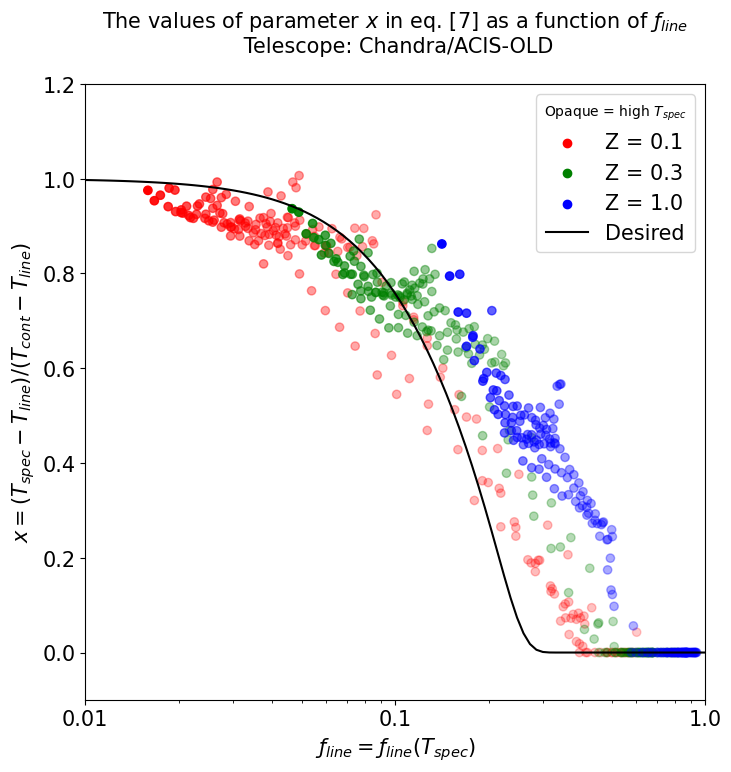

In [28]:
%run -i 'utils/fit_lines.py'
%run -i 'utils/fit_cont.py'
%run -i 'utils/fit_reals.py'

%run -i 'utils/fit_main.py'
%run -i 'utils/ave_lines.py'
%run -i 'utils/avt_cont.py'

iks_all = []
fline_all = []
tspec_all = []

for metallicity in metallicities:

    for T_min, T_max in list(zip(T_mins, T_maxs)):

        name_key = str(metallicity)+': '+str(T_min)+'-'+str(T_max)
         
        Tspec_list1 = Tspec_cont_f6[name_key]  # continuum
        Tspec_list2 = single_T_fit_f6[name_key] # realistic metallicities
        #Tspec_list3 = Tspec_lines_f6[name_key]  # line-dominated
        
        # line-dominated from <E>
        Tspec_list3 = calc_Tspec_from_avE(T_min, T_max, len(f_min), telescope)   
    
        # continuum from eq. 4,6
        #Tspec_list1 = get_Tspec_continuum_eq46(f_min, T_min, T_max, alfa, telescope)
        
        num_iks = [tsp - tli for tsp, tli in zip(Tspec_list2, Tspec_list3)]
        denom_iks = [tco - tli for tco, tli in zip(Tspec_list1, Tspec_list3)]
                
        for i in range(0, len(denom_iks)):
            if denom_iks[i] == 0:
                denom_iks[i] = 0.00001
        
        iks = [numx/denomx for numx, denomx in zip(num_iks, denom_iks)]

        #Flux_list1 = Flux_cont_f6[name_key] # continuum
        #Flux_list2 = Flux_fit_f6[name_key] # realistic metallicities
        #Flux_list3 = Flux_lines_f6[name_key] # line-dominated

        #fline = [Fli/(Fli + Fco) for Fli, Fco in zip(Flux_list3, Flux_list1)]
        #fline = [1-Fco/Fsum for Fco, Fsum in zip(Flux_list1, Flux_list2)]
        #fline = [1-Fco/(Fco+Fli) for Fco, Fli in zip(Flux_list1, Flux_list3)]
        
        fline = [f_line(telescope, tttt, 'rate', metallicity) for tttt in Tspec_list2]
        
        iks_all.append(iks[1:-1])
        fline_all.append(fline[1:-1])
        tspec_all.append(Tspec_list2[1:-1])

        a=2
        
        if a==1:
            
            plt.figure(figsize=(17,8))
            plt.suptitle(f'$T_{{min}}={T_min} \ keV, \ T_{{max}}={T_max} \ keV.$ Z = '+str(metallicity)+'\n \n', fontsize = 25)

            plt.subplot(1,2,1)
            # continuum
            plt.plot(f_min, Tspec_list1, linestyle = '--', linewidth = 2, color = 'black')
            # realistic metallicities
            plt.scatter(f_min, Tspec_list2)#, color='black')
            # line-dominated
            plt.plot(f_min, Tspec_list3, linestyle=':', color='black')
        
            #print('F_cnt + F_lin = F_sum =?= F_fit')
            #for i in range(0, len(f_min)):
            #    print(f'{Flux_list2[i]*10**12:.2f}')
                #print(f'{Flux_list1[i]*10**12:.2f} + {Flux_list3[i]*10**12:.2f} = {Flux_list1[i]*10**12 + Flux_list3[i]*10**12:.2f} =?= {Flux_list2[i]*10**12:.2f} ....... f_line = {fline[i]:.2f}, x = {iks[i]:.2f}')

            handles, labels = plt.gca().get_legend_handles_labels()
            line_n = Line2D([], [], label='Continuum from <T>', color='black', linestyle='--', linewidth=2)
            line_e = Line2D([], [], label='Lines from <E>', color='black', linestyle=':', linewidth=2)
            dots_f = Line2D([], [], label='Single-T fit', color='black', marker='.', linestyle='None', markersize=12)
            handles.extend([line_n, line_e, dots_f])
            plt.legend(handles=handles, fontsize=15)

            #plt.ylim(0, 12.1)
            plt.xticks(size=15)
            plt.yticks(size=15)
            plt.xlabel('$f_{min}$', fontsize = 15)
            plt.ylabel('$T_{spec},$ keV', fontsize = 15)
            plt.title('Spectra with realistic metallicities ('+telescope+')', fontsize = 15)

            plt.subplot(1,2,2)
            plt.scatter(fline[1:-1], iks[1:-1])
            ii = np.linspace(0, 1.2, 101)
            plt.plot(ii, universal_function(ii, 0.19, 0.25, 1.00), color='black', linestyle='-', label = 'Desired')
            plt.xscale('log')
            #plt.ylim(-0.1, 1.2)
            plt.xticks([0.01, 0.1, 1.0], [0.01, 0.1, 1.0], size=15)
            plt.yticks(size=15)
            plt.xlabel('$ƒ_{line}$', fontsize = 15)
            plt.ylabel('$x$', fontsize = 15)
            #plt.title('Spectra with realistic metallicities ('+telescope+') \n', fontsize = 15)
            plt.show()
            
plt.figure(figsize=(8,8))

fline_all = [item for sublist in fline_all for item in sublist]
iks_all = [item for sublist in iks_all for item in sublist]
tspec_all = [item for sublist in tspec_all for item in sublist]

#plt.scatter(fline_all, iks_all, color='black')
tret = int(len(fline_all)/3)
plt.scatter(fline_all[0:tret], iks_all[0:tret],               label = 'Z = 0.1', color='red', alpha = [1-(1-a/np.max(tspec_all[0:tret]))/1.2 for a in tspec_all[0:tret]])
plt.scatter(fline_all[tret:2*tret], iks_all[tret:2*tret],     label = 'Z = 0.3', color='green', alpha = [1-(1-a/np.max(tspec_all[tret:2*tret]))/1.2 for a in tspec_all[tret:2*tret]])
plt.scatter(fline_all[2*tret:3*tret], iks_all[2*tret:3*tret], label = 'Z = 1.0', color='blue', alpha = [1-(1-a/np.max(tspec_all[2*tret:3*tret]))/1.2 for a in tspec_all[2*tret:3*tret]])

#for i in range(0, tret):
#    plt.plot([fline_all[i], fline_all[i+tret], fline_all[i+2*tret]], [iks_all[i], iks_all[i+tret], iks_all[i+2*tret]], color='grey', alpha=0.3)

if telescope == 'Chandra/ACIS-OLD':
    pars_desired = [0.19, 0.25, 1.00]
elif telescope == 'XMM-Newton/MOS':
    pars_desired = [0.19, 0.22, 1.00]

#ii = np.linspace(0, 1.2, 101)
ii = np.logspace(np.log10(0.01), np.log10(1.2), 101)
plt.plot(ii, universal_function(ii, *pars_desired), color='black', linestyle='-', label = 'Desired')

leg = plt.legend(title='Opaque = high $T_{spec}$', fontsize=15)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xscale('log')
plt.ylim(-0.1, 1.2)
plt.xlim(0.01, 0.1)
plt.xticks([0.01, 0.1, 1.0], [0.01, 0.1, 1.0], size=15)
plt.yticks(size=15)
plt.xlabel('$ƒ_{line} = ƒ_{line} (T_{spec})$', fontsize = 15)
plt.ylabel('$x = (T_{spec}-T_{line})/(T_{cont}-T_{line})$', fontsize = 15)
plt.title('The values of parameter $x$ in eq. [7] as a function of $ƒ_{line}$ \n Telescope: '+telescope+'\n', fontsize = 15)

plt.show()

In [543]:
f_min = np.linspace(0, 1, 21)

T_mins = (0.5, 1., 2., 3., 0.5, 1., 2., 3., 0.5, 1., 2., 3.)
T_maxs = (1. , 2., 4., 6., 1.5, 3., 6., 9., 2. , 4., 8., 12.)

metallicities = (0.1, 0.3, 1.0)

In [577]:
import scipy.optimize
from matplotlib.gridspec import GridSpec

In [578]:
x111 = fline_all
y111 = iks_all
z111 = tspec_all

print(len(x111))
print(len(y111))
print(len(z111))

for j in range(0, len(y111)):
    
    if y111[j] > 1.2 or y111[j] <= -0.1:
        x111[j] = "k"
        y111[j] = "k"
        z111[j] = "k"

x111 = [i for i in x111 if i != "k"]
y111 = [i for i in y111 if i != "k"]
z111 = [i for i in z111 if i != "k"]

print(len(x111))
print(len(y111))
print(len(z111))

684
684
684
678
678
678


In [579]:
#x111 = [item for sublist in fline_all[0:36] for item in sublist]
#y111 = [item for sublist in iks_all[0:36] for item in sublist]

#x111 = fline_all
#y111 = iks_all
#z111 = tspec_all

popt, pcov = scipy.optimize.curve_fit(universal_function, x111, y111, p0=pars_desired)#, bounds=((0, 0.5), (0, 0.5), (0.5, 1.5)))

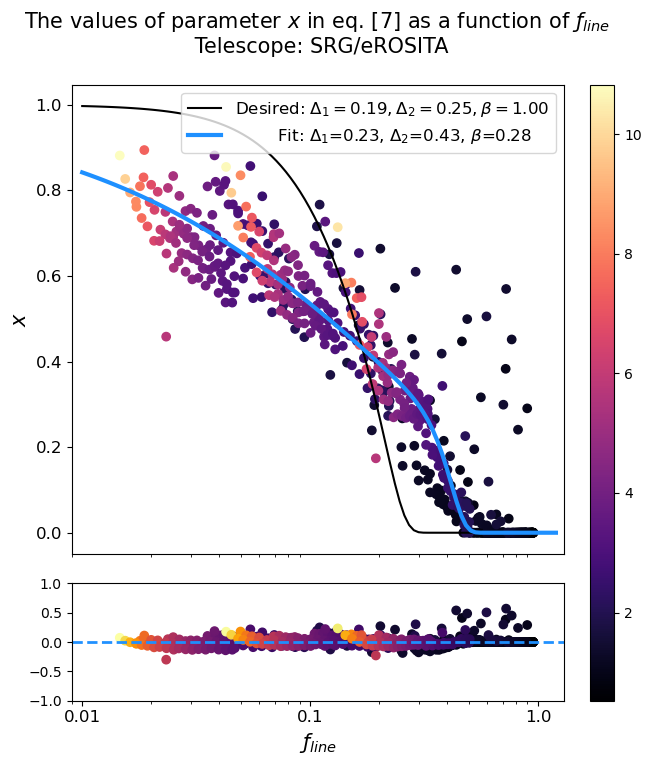

In [580]:
fig = plt.figure(figsize=(7,8))

gs = GridSpec(2, 2, height_ratios=[4, 1], width_ratios=[20, 1], hspace = 0.1, wspace = 0.1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[0:2, 1:2])

plot1 = ax1.scatter(x111, y111, c=z111, cmap='magma')#, alpha = [a/np.max(tspec_all) for a in tspec_all])

#ii = np.linspace(0, 1.2, 101)
ii = np.logspace(np.log10(0.01), np.log10(1.2), 101)
ax1.plot(ii, universal_function(ii, 0.19, 0.25, 1.00), color='black', linestyle='-', label = 'Desired: $\Delta_1=0.19, \Delta_2=0.25, \\beta=1.00$')
ax1.plot(ii, universal_function(ii, *popt), color='dodgerblue', linewidth = 3, label='        Fit: $\Delta_1$=%.2f, $\Delta_2$=%.2f, $\\beta$=%.2f' % tuple(popt))

ax1.legend(fontsize=12)
ax1.set_xscale('log')
ax1.set_xlim(0.009, 1.3)
#ax1.set_ylim(-0.1, 1.2)
ax1.set_xticks([],[], size=15)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('$x$', fontsize = 15)

fig.colorbar(mappable=plot1, cax=ax3)

ax2.axhline(0, color='dodgerblue', linewidth = 2, linestyle='--', alpha= 0.99)
ax2.scatter(x111, y111-universal_function(x111, *popt), c=z111, cmap='inferno')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-1,1)
ax2.set_xscale('log')
ax2.set_xticks([0.01, 0.1, 1.0], [0.01, 0.1, 1.0], size=12)
ax2.set_xlabel('$ƒ_{line}$', fontsize = 15)

ax1.set_title('The values of parameter $x$ in eq. [7] as a function of $ƒ_{line}$ \n Telescope: '+telescope+'\n', fontsize = 15)

plt.show()

In [ ]:
import emcee

def model(params, x):
    d1, d2, b = params
    return np.exp( -(x/d1)**(2*b) ) * np.exp( -(x/d2)**(8) )

def lnlike(params, x, y):
    d1, d2, b = params
    # the likelihood is sum of the lot of normal distributions
    return -0.5 * np.sum( ((y - model(params, x))/1 )**2 )# + np.log(2*np.pi*sigmu**2) )
    
def lnprior(params):
    # The parameters are stored as a vector of values, so unpack them
    d1, d2, b = params
    # Bounds
    if 0.0 < d1 < 0.5 and 0.0 < d2 < 0.5 and 0.5 < b < 1.5:
        return 0.0
    return -np.inf

def lnprob(params, x, y):
    lp = lnprior(params)
    if np.isfinite(lp):
          return lp + lnlike(params, x, y)
    else:
          return -np.inf

In [ ]:
#def best_with_emcee(dtTrue, dmTrue, lengthofchain, arguments, draw):

true_delta1, true_delta2, true_beta = 0.25, 0.25, 1.0

nwalkers = 100
initial = [0.5, 0.5, 0.5]
ndim = len(initial)

# make the initial values more noisy
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (x111, y111) )

#p0, _, _ = sampler.run_mcmc(p0, 500, progress=True)
#sampler.reset()
lengthofchain = 500
pos,prob,state = sampler.run_mcmc(p0, lengthofchain, progress = False)

In [ ]:
samples = sampler.flatchain
params_best  = samples[np.argmax(sampler.flatlnprobability)]
#randoms = np.random.randint(len(samples), size=50)

#print("Initial dt = {0:.3f}".format(initial[0]))
#print("Initial dm = {0:.3f}".format(initial[1]))
#print("sigmu = {0:.3f}".format(optim.x[2]))

#print('Best dt = {0:.3f}'.format(s[0]))
#print('Best dmu = {0:.3f}'.format(s[1])) 
#print('or best magnification ratio = {0:.3f}'.format(10**(-0.4*s[1])) )


#for params in samples[randoms]:
#  plt.plot(arguments[0], model(params, arguments[0], arguments[2], arguments[3]), color="b", alpha=0.1)

#best_fit_model = model(params_best, arguments[0], arguments[2], arguments[3])

#return params_best[0], params_best[1], samples[randoms]

#best_dt, best_dm, srand = best_with_MCMC(dtTrue=dt_true, 
#                              dmTrue=dm_true, 
#                              lengthofchain=500, 
#                              arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
#                              draw=True)
#print(best_dt, best_dm)
params_best

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(x111, y111)

#ii = np.linspace(0, 1.2, 101)
ii = np.logspace(np.log10(0.01), np.log10(1.2), 101)
plt.plot(ii, universal_function(ii, 0.19, 0.25, 1.00), color='black', linestyle='-', label = 'Desired')
plt.plot(ii, model(params_best, ii), color='red', linestyle='-', label = 'emcee')

plt.legend(fontsize=15)
plt.xscale('log')
plt.ylim(-0.1, 1.2)
plt.xticks([0.01, 0.1, 1.0], [0.01, 0.1, 1.0], size=15)
plt.yticks(size=15)
plt.xlabel('$ƒ_{line}$', fontsize = 15)
plt.ylabel('$x$', fontsize = 15)
#plt.title('Spectra with realistic metallicities ('+telescope+') \n', fontsize = 15)
#plt.savefig('Fig6_'+telescope+'.png')
plt.show()

In [ ]:

    #if False:
    #  fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    #  chain = sampler.get_chain()
    #  labels = ['$\Delta t$', '$\Delta m$', '$\sigma_m$']
    #  for i in range(ndim):
    #      ax = axes[i]
    #      ax.plot(chain[:, :, i], "k", alpha=0.3)
    #      ax.set_xlim(0, len(chain))
    #      ax.set_ylabel(labels[i])
    #      ax.yaxis.set_label_coords(-0.1, 0.5)
    #  axes[-1].set_xlabel("step number")
      #tau = sampler.get_autocorr_time()
      #print(tau)
      #flat_samples = sampler.get_chain()#discard=400, thin=1, flat=False)
      #print(flat_samples.shape)

    #  fig = corner.corner(sampler.flatchain, 
    #                      show_titles=True, 
    #                      labels=['$\Delta t$', '$\Delta m$'], 
    #                      truths=[dt_true, dm_true], 
    #                      scale_hist=True, 
    #                      quantiles=[0.16, 0.5, 0.84])
